# Libraries

In [1]:
import os
import pandas as pd
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import tukey_hsd
import matplotlib.pyplot as plt
import pingouin as pg
from pingouin import ancova
from matplotlib.patches import Patch
#import statannotations as sa
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
import xlsxwriter
import lxml

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from datetime import datetime
from scipy.signal import correlate

# Directories


In [2]:
ROOT = Path().resolve().parent      # one level up from current dir
cardiac_timecourse_df = pd.read_excel(ROOT / "data/Extra-cranial_physiological_factors/timeseries_cardiac.xls")
respiration_timecourse_df = pd.read_excel(ROOT / "data/Extra-cranial_physiological_factors/timeseries_respiration.xls")


cardiac_df = pd.read_excel(ROOT / "data/Extra-cranial_physiological_factors/Final_table_cardiac.xls")
respiration_df = pd.read_excel(ROOT / "data/Extra-cranial_physiological_factors/Final_table_respiration.xls")

null_cardiac_csf_df = pd.read_excel(ROOT / "data/Extra-cranial_physiological_factors/null_cardiac_csf.xls")
null_cardiac_pfi_df = pd.read_excel(ROOT / "data/Extra-cranial_physiological_factors/null_cardiac_pfi.xls")
null_cardiac_d_dt_pfi_df = pd.read_excel(ROOT / "data/Extra-cranial_physiological_factors/null_cardiac_d_dt_pfi.xls")
null_cardiac_gm_df = pd.read_excel(ROOT / "data/Extra-cranial_physiological_factors/null_cardiac_gm.xls")
null_cardiac_d_dt_gm_df = pd.read_excel(ROOT / "data/Extra-cranial_physiological_factors/null_cardiac_d_dt_gm.xls")
null_respiration_csf_df = pd.read_excel(ROOT / "data/Extra-cranial_physiological_factors/null_respiration_csf.xls")
null_respiration_pfi_df = pd.read_excel(ROOT / "data/Extra-cranial_physiological_factors/null_respiration_pfi.xls")
null_respiration_d_dt_pfi_df = pd.read_excel(ROOT / "data/Extra-cranial_physiological_factors/null_respiration_d_dt_pfi.xls")
null_respiration_gm_df = pd.read_excel(ROOT / "data/Extra-cranial_physiological_factors/null_respiration_gm.xls")
null_respiration_d_dt_gm_df = pd.read_excel(ROOT / "data/Extra-cranial_physiological_factors/null_respiration_d_dt_gm.xls")


# Edit the RC file

In [3]:
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "svg.fonttype": "none"
})

# Set Tick Size

In [4]:
sns.set(rc={'axes.linewidth': 2.0})
sns.set_style("white")
sns.set_style("ticks")

# Prep the dataframes

In [5]:
cardiac_timecourse = cardiac_timecourse_df
respiration_timecourse = cardiac_timecourse_df

cardiac = cardiac_df
respiration = respiration_df

null_cardiac_csf = null_cardiac_csf_df
null_cardiac_pfi = null_cardiac_pfi_df
null_cardiac_d_dt_pfi = null_cardiac_d_dt_pfi_df
null_cardiac_gm = null_cardiac_gm_df
null_cardiac_d_dt_gm = null_cardiac_d_dt_gm_df
null_respiration_csf = null_respiration_csf_df
null_respiration_pfi = null_respiration_pfi_df
null_respiration_d_dt_pfi = null_respiration_d_dt_pfi_df
null_respiration_gm = null_respiration_gm_df
null_respiration_d_dt_gm = null_respiration_d_dt_gm_df

# Prep the dataframes heartbeat and respiration

In [6]:


## - THIS IS FOR PFI CARDIAC
# Select columns with names matching "_ventricle"
timecourse_columns_cardiac_pfi = [col for col in cardiac.columns if col.endswith("ventricle_gradient")]
# Extract relevant cardiac data
timecourse_data_cardiac_pfi = cardiac[timecourse_columns_cardiac_pfi].copy()

# Add timepoint column (number of rows)
timecourse_data_cardiac_pfi['timepoint'] = range(len(timecourse_data_cardiac_pfi))
timecourse_data_cardiac_pfi['timepoint'] = timecourse_data_cardiac_pfi['timepoint'] * (0.98/18)
timecourse_data_cardiac_pfi['subject'] = "SubjectX"

# Convert to long format for Seaborn
long_df_cardiac_pfi = timecourse_data_cardiac_pfi.melt(
    id_vars=['subject', 'timepoint'],  # Keeping 'timepoint' and 'subject' as identifiers
    var_name='measurement',  # This will contain '_ventricle' column names
    value_name='value'  # The actual data
)

# Extract numerical timepoints for sorting/plotting (if needed)
long_df_cardiac_pfi['measurement'] = long_df_cardiac_pfi['measurement'].str.extract(r'(\d+)').astype(float)

long_df_cardiac_pfi["physiology"] = "Cardiac-locked PFI'"


## - THIS IS FOR PFI Respiration
# Select columns with names matching "_ventricle"
timecourse_columns_respiration_pfi = [col for col in respiration.columns if col.endswith("ventricle_gradient")]
# Extract relevant cardiac data
timecourse_data_respiration_pfi = respiration[timecourse_columns_respiration_pfi].copy()

# Add timepoint column (number of rows)
timecourse_data_respiration_pfi['timepoint'] = range(len(timecourse_data_respiration_pfi))
timecourse_data_respiration_pfi['timepoint'] = timecourse_data_respiration_pfi['timepoint'] * (3.61/18)
# Add subject column (all rows labeled as "SubjectX" for now)
timecourse_data_respiration_pfi['subject'] = "SubjectX"

# Convert to long format for Seaborn
long_df_respiration_pfi = timecourse_data_respiration_pfi.melt(
    id_vars=['subject', 'timepoint'],  # Keeping 'timepoint' and 'subject' as identifiers
    var_name='measurement',  # This will contain '_ventricle' column names
    value_name='value'  # The actual data
)

# Extract numerical timepoints for sorting/plotting (if needed)
long_df_respiration_pfi['measurement'] = long_df_respiration_pfi['measurement'].str.extract(r'(\d+)').astype(float)

long_df_respiration_pfi["physiology"] = "Respiration-locked PFI'"

## - THIS IS FOR CSF CARDIAC
# Select columns with names matching "_ventricle"
timecourse_columns_cardiac_csf = [col for col in cardiac.columns if col.endswith("_csf")]
# Extract relevant cardiac data
timecourse_data_cardiac_csf = cardiac[timecourse_columns_cardiac_csf].copy()

# Add timepoint column (number of rows)
timecourse_data_cardiac_csf['timepoint'] = range(len(timecourse_data_cardiac_csf))
timecourse_data_cardiac_csf['timepoint'] = timecourse_data_cardiac_csf['timepoint'] * (0.98/18)

# Add subject column (all rows labeled as "SubjectX" for now)
timecourse_data_cardiac_csf['subject'] = "SubjectX"

# Convert to long format for Seaborn
long_df_cardiac_csf = timecourse_data_cardiac_csf.melt(
    id_vars=['subject', 'timepoint'],  # Keeping 'timepoint' and 'subject' as identifiers
    var_name='measurement',  # This will contain '_ventricle' column names
    value_name='value'  # The actual data
)

# Extract numerical timepoints for sorting/plotting (if needed)
long_df_cardiac_csf['measurement'] = long_df_cardiac_csf['measurement'].str.extract(r'(\d+)').astype(float)

long_df_cardiac_csf["physiology"] = "Cardiac-locked CSF"

## - THIS IS FOR CSF Respiration
# Select columns with names matching "_ventricle"
timecourse_columns_respiration_csf = [col for col in respiration.columns if col.endswith("_csf")]
# Extract relevant cardiac data
timecourse_data_respiration_csf = respiration[timecourse_columns_respiration_csf].copy()

# Add timepoint column (number of rows)
timecourse_data_respiration_csf['timepoint'] = range(len(timecourse_data_respiration_csf))
timecourse_data_respiration_csf['timepoint'] = timecourse_data_respiration_csf['timepoint'] * (3.61/18)
# Add subject column (all rows labeled as "SubjectX" for now)
timecourse_data_respiration_csf['subject'] = "SubjectX"

# Convert to long format for Seaborn
long_df_respiration_csf = timecourse_data_respiration_csf.melt(
    id_vars=['subject', 'timepoint'],  # Keeping 'timepoint' and 'subject' as identifiers
    var_name='measurement',  # This will contain '_ventricle' column names
    value_name='value'  # The actual data
)

# Extract numerical timepoints for sorting/plotting (if needed)
long_df_respiration_csf['measurement'] = long_df_respiration_csf['measurement'].str.extract(r'(\d+)').astype(float)

long_df_respiration_csf["physiology"] = "Respiration-locked CSF"

## - THIS IS FOR GM CARDIAC
# Select columns with names matching "_ventricle"
timecourse_columns_cardiac_gm = [col for col in cardiac.columns if col.endswith("gm_gradient")]
# Extract relevant cardiac data
timecourse_data_cardiac_gm = cardiac[timecourse_columns_cardiac_gm].copy()

# Add timepoint column (number of rows)
timecourse_data_cardiac_gm['timepoint'] = range(len(timecourse_data_cardiac_gm))
timecourse_data_cardiac_gm['timepoint'] = timecourse_data_cardiac_gm['timepoint'] * (0.98/18)
timecourse_data_cardiac_gm['subject'] = "SubjectX"

# Convert to long format for Seaborn
long_df_cardiac_gm = timecourse_data_cardiac_gm.melt(
    id_vars=['subject', 'timepoint'],  # Keeping 'timepoint' and 'subject' as identifiers
    var_name='measurement',  # This will contain '_ventricle' column names
    value_name='value'  # The actual data
)

# Extract numerical timepoints for sorting/plotting (if needed)
long_df_cardiac_gm['measurement'] = long_df_cardiac_gm['measurement'].str.extract(r'(\d+)').astype(float)

long_df_cardiac_gm["physiology"] = "Cardiac-locked GM'"


## - THIS IS FOR GM Respiration
# Select columns with names matching "_ventricle"
timecourse_columns_respiration_gm = [col for col in respiration.columns if col.endswith("gm_gradient")]
# Extract relevant cardiac data
timecourse_data_respiration_gm = respiration[timecourse_columns_respiration_gm].copy()

# Add timepoint column (number of rows)
timecourse_data_respiration_gm['timepoint'] = range(len(timecourse_data_respiration_gm))
timecourse_data_respiration_gm['timepoint'] = timecourse_data_respiration_gm['timepoint'] * (3.61/18)
# Add subject column (all rows labeled as "SubjectX" for now)
timecourse_data_respiration_gm['subject'] = "SubjectX"

# Convert to long format for Seaborn
long_df_respiration_gm = timecourse_data_respiration_gm.melt(
    id_vars=['subject', 'timepoint'],  # Keeping 'timepoint' and 'subject' as identifiers
    var_name='measurement',  # This will contain '_ventricle' column names
    value_name='value'  # The actual data
)

# Extract numerical timepoints for sorting/plotting (if needed)
long_df_respiration_gm['measurement'] = long_df_respiration_gm['measurement'].str.extract(r'(\d+)').astype(float)

long_df_respiration_gm["physiology"] = "Respiration-locked GM'"

# Heartbeat

# Panel 5A

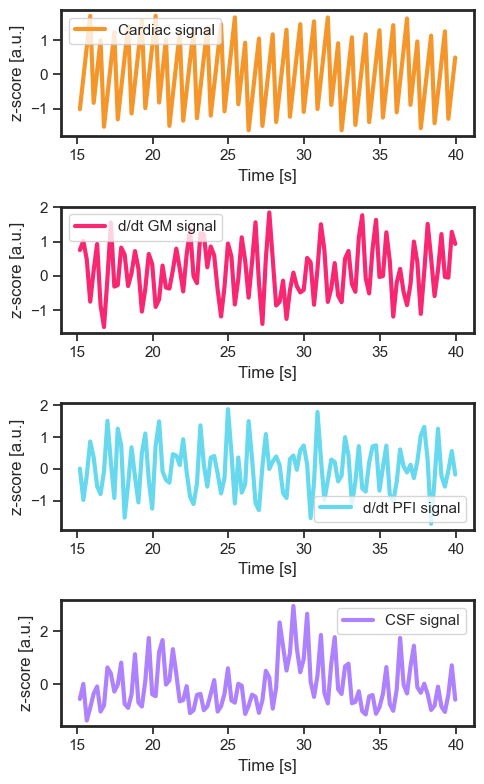

<Figure size 640x480 with 0 Axes>

In [7]:
# Create the single subject timecourse
ex_timecourse = cardiac_timecourse


# Extract the timecourses for the specific subject
Subject = pd.DataFrame()
Subject['time'] = ex_timecourse.iloc[:,0]
Subject['cardiac'] = stats.zscore(ex_timecourse.iloc[:,1])
Subject['respiration'] = stats.zscore(ex_timecourse.iloc[:,2])
Subject['pfi'] = stats.zscore(ex_timecourse.iloc[:,3])
Subject['csf'] = stats.zscore(ex_timecourse.iloc[:,4])
Subject['gm'] = stats.zscore(ex_timecourse.iloc[:,5])

# Display the new DataFrame
#print(Subject)
Subject_short = Subject[(Subject['time'] >= 15) & (Subject['time'] <= 40)]

# Create a figure with 4 subplots stacked vertically
fig, axs = plt.subplots(4, 1, figsize=(5,8))


sns.lineplot(x="time", y='cardiac', data=Subject_short, ax=axs[0], label='Cardiac signal', color=((244/255, 150/255, 42/255)), linewidth=3, legend=True)
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('z-score [a.u.]')


sns.lineplot(x="time", y='pfi', data=Subject_short, ax=axs[2], label='d/dt PFI signal', color=(102/255, 217/255, 239/255), linewidth=3, legend=True)
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('z-score [a.u.]')


sns.lineplot(x="time", y='csf', data=Subject_short, ax=axs[3], label='CSF signal', color=(174/255, 129/255, 255/255), linewidth=3, legend=True)
axs[3].set_xlabel('Time [s]')
axs[3].set_ylabel('z-score [a.u.]')

sns.lineplot(x="time", y='gm', data=Subject_short, ax=axs[1], label='d/dt GM signal', color=(249/255, 38/255, 114/255), linewidth=3, legend=True)
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('z-score [a.u.]')

# Adjust layout for better spacing
plt.tight_layout()


# Show the plot
plt.show()

#fig.legend(loc='lower right')
sns.despine(right=True, left=True)



# Save the figure -------
#image_path = os.path.join(outDir, f'Physiology_tc_sub-01-11.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Physiology_tc_sub-01-11.svg')
#fig.savefig(image_path_svg, transparent=True)

# Panel 5B

[ 0.36411026  1.07568398  0.15254128  0.87544398  0.49531655  0.30307469
  0.34783487  0.60414159  0.32234533 -0.12558787  0.18997449  0.49751077
 -0.12007203]
0.3832552224477694
0       0.065521
1      -0.073464
2      -0.138524
3      -0.156011
4      -0.075182
          ...   
9994    0.110022
9995    0.143639
9996    0.087809
9997    0.039760
9998    0.059139
Name: 0.08048130888361678, Length: 9999, dtype: float64
Mann-Whitney U Test p-value: 9.586411911097846e-06
[-0.39438868 -0.90347458 -0.16211035 -0.76170141 -0.70147953 -0.66916271
 -0.96012004 -0.68725137 -0.49953237  0.12526106 -0.39082514 -0.57257463
  0.12911205]
-0.49601905400380475
0       0.060520
1      -0.022516
2       0.103456
3       0.141820
4       0.115782
          ...   
9994    0.015359
9995    0.020087
9996   -0.033894
9997    0.003297
9998   -0.000209
Name: -0.012851872363352994, Length: 9999, dtype: float64
Mann-Whitney U Test p-value: 9.719503470626e-06


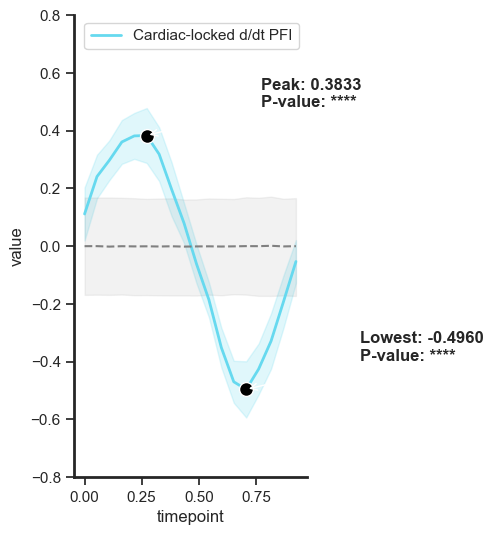

Computed 9999 null amplitudes
Example null amplitudes: 0    0.219523
1    0.349700
2    0.350217
3    0.373261
4    0.320629
5    0.302905
6    0.303953
7    0.380064
8    0.279849
9    0.301314
dtype: float64
Mean null amplitude: 0.3211
Subject amplitudes:
[0.75849894 2.19003214 0.32134441 1.65610673 1.19679608 1.44548945
 1.6041835  1.48526263 0.99702128 0.29349693 0.95488464 1.08887911
 0.40288911]
Median subject amplitude: 1.0889
Mean null amplitude: 0.3211
Mann-Whitney U p-value: 0.00000


In [8]:
####
# Combine both conditions: PFI
combined_df_pfi = pd.concat([long_df_cardiac_pfi, long_df_respiration_pfi])
# Combine both conditions: CSF
combined_df_csf = pd.concat([long_df_cardiac_csf, long_df_respiration_csf])


first_value = 0

# Shift all values so the first point is at zero
long_df_cardiac_pfi["value"] -= first_value

# Now mean the null distribution as well (10.000, 18)
first_value_null = null_cardiac_d_dt_pfi.mean(axis=0).iloc[0]
null_cardiac_d_dt_pfi = null_cardiac_d_dt_pfi - first_value_null
null_mean = np.mean(null_cardiac_d_dt_pfi, axis=0)  # Mean over permutations
lower_bound = np.percentile(null_cardiac_d_dt_pfi, 2.5, axis=0)  # 2.5th percentile
upper_bound = np.percentile(null_cardiac_d_dt_pfi, 97.5, axis=0)  # 97.5th percentile

# Define timepoints (assuming 18 bins), exemplary from subject one
timepoints = long_df_cardiac_pfi.loc[long_df_cardiac_pfi['measurement'] == 1, 'timepoint']


# Define your figure with 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(figsize=(3,6))


# Plot PFI using Seaborn

sns.lineplot(
    data=long_df_cardiac_pfi,
    x='timepoint',  # Changed from 'subject' to 'timepoint'
    y='value',
    #hue='physiology',
    errorbar='se',  # Shaded region shows standard deviation
    estimator='mean',  # Mean line
    linewidth=2,
    color=(102/255, 217/255, 239/255),  #((171/255, 157/255, 242/255))
    ax=ax,
    label='Cardiac-locked d/dt PFI'
)

# Plot null distribution mean with shaded confidence interval
ax.plot(timepoints, null_mean, color="gray", linestyle="dashed", label="Null Mean")
ax.fill_between(timepoints, lower_bound, upper_bound, color="gray", alpha=0.1, label="Null 95% CI")
    
# Now do the statistics - Peak
# Extract peak value and index
mean_pfi = long_df_cardiac_pfi.groupby("timepoint")["value"].mean()
peak_timepoint = mean_pfi.idxmax()  # Get timepoint of the max value
peak_value = mean_pfi.max()  # Get the max value itself
time_interval = timepoints[1] - timepoints[0]  # Interval between timepoints
peak_timepoint_index = int(round(peak_timepoint / time_interval))

# Extract observed values at the peak timepoint
observed_values_at_peak = long_df_cardiac_pfi.loc[long_df_cardiac_pfi['timepoint'] == peak_timepoint, 'value'].values

# Extract null distribution values at the same peak timepoint index
null_values_at_peak = null_cardiac_d_dt_pfi.iloc[:, peak_timepoint_index]

print(observed_values_at_peak)
print(observed_values_at_peak.mean())
print(null_values_at_peak)
# Perform Mann-Whitney U test to compare observed values at peak with null values at the same timepoint
stat, p_value = mannwhitneyu(observed_values_at_peak, null_values_at_peak, alternative='two-sided')

# Step 5: Output the p-value
print(f"Mann-Whitney U Test p-value: {p_value}")
# Print formatted p-value or asterisks
if p_value < 0.00001:
    p_value = '****'
else:
    p_value = f'{p_value:.5f}'  # Format the p-value with 5 decimal places

# Mark the peak value with a circle
ax.scatter(peak_timepoint, peak_value, color="black", edgecolor="white", s=100, zorder=3, label="Observed Peak")

# Check if p_value is a string (i.e., '****')
if isinstance(p_value, str):
    annotation_text = f"Peak: {peak_value:.4f}\nP-value: {p_value}"
else:
    annotation_text = f"Peak: {peak_value:.4f}\nP-value: {p_value:.4f}"

# Annotate peak value and p-value
ax.annotate(annotation_text, 
            xy=(peak_timepoint, peak_value), 
            xytext=(peak_timepoint + 0.5, peak_value + 0.1),  # Offset text
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            fontsize=12, weight='bold')

# Now do the statistics - Lowest
# Extract peak value and index
mean_pfi = long_df_cardiac_pfi.groupby("timepoint")["value"].mean()
peak_timepoint = mean_pfi.idxmin()  # Get timepoint of the max value
peak_value = mean_pfi.min()  # Get the max value itself
time_interval = timepoints[1] - timepoints[0]  # Interval between timepoints
peak_timepoint_index = int(round(peak_timepoint / time_interval))

# Extract observed values at the peak timepoint
observed_values_at_peak = long_df_cardiac_pfi.loc[long_df_cardiac_pfi['timepoint'] == peak_timepoint, 'value'].values

# Extract null distribution values at the same peak timepoint index
null_values_at_peak = null_cardiac_d_dt_pfi.iloc[:, peak_timepoint_index]

print(observed_values_at_peak)
print(observed_values_at_peak.mean())
print(null_values_at_peak)
# Perform Mann-Whitney U test to compare observed values at peak with null values at the same timepoint
stat, p_value = mannwhitneyu(observed_values_at_peak, null_values_at_peak, alternative='two-sided')

# Step 5: Output the p-value
print(f"Mann-Whitney U Test p-value: {p_value}")
# Print formatted p-value or asterisks
if p_value < 0.00001:
    p_value = '****'
else:
    p_value = f'{p_value:.5f}'  # Format the p-value with 5 decimal places

# Mark the peak value with a circle
ax.scatter(peak_timepoint, peak_value, color="black", edgecolor="white", s=100, zorder=3, label="Observed Lowest")

# Check if p_value is a string (i.e., '****')
if isinstance(p_value, str):
    annotation_text = f"Lowest: {peak_value:.4f}\nP-value: {p_value}"
else:
    annotation_text = f"Lowest: {peak_value:.4f}\nP-value: {p_value:.4f}"

# Annotate peak value and p-value
ax.annotate(annotation_text, 
            xy=(peak_timepoint, peak_value), 
            xytext=(peak_timepoint + 0.5, peak_value + 0.1),  # Offset text
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            fontsize=12, weight='bold')

sns.despine()
plt.ylim(-0.8,0.8)
plt.show()

# Save the figure -------
#image_path = os.path.join(outDir, f'PFI_cardiac.png')
#fig.savefig(image_path,dpi=600, bbox_inches='tight')
#---
#image_path_svg = os.path.join(outDir, f'PFI_cardiac.svg')
#fig.savefig(image_path_svg)


# ==============================================================
# Amplitude Test: Observed (peak - trough) vs Null Distribution
# ==============================================================


# Each row is one permutation → amplitude = max - min across bins
null_amplitudes = null_cardiac_d_dt_pfi.max(axis=1) - null_cardiac_d_dt_pfi.min(axis=1)

print(f"Computed {len(null_amplitudes)} null amplitudes")
print(f"Example null amplitudes: {null_amplitudes[:10]}")
print(f"Mean null amplitude: {null_amplitudes.mean():.4f}")

# Subject amplitudes: max-min per subject trace
subject_amplitudes = (
    long_df_cardiac_pfi.groupby("measurement")["value"].apply(lambda x: x.max() - x.min())
)

print("Subject amplitudes:")
print(subject_amplitudes.values)

# Mann–Whitney U: compares subject amplitude distribution vs null
stat, p_value_subjects = mannwhitneyu(subject_amplitudes, null_amplitudes, alternative="two-sided")

print(f"Median subject amplitude: {subject_amplitudes.median():.4f}")
print(f"Mean null amplitude: {null_amplitudes.mean():.4f}")
print(f"Mann-Whitney U p-value: {p_value_subjects:.5f}")

# Panel 5C

      subject  timepoint  measurement     value          physiology
0    SubjectX   0.000000          1.0 -0.153582  Cardiac-locked GM'
1    SubjectX   0.054444          1.0 -0.099102  Cardiac-locked GM'
2    SubjectX   0.108889          1.0 -0.043656  Cardiac-locked GM'
3    SubjectX   0.163333          1.0 -0.013585  Cardiac-locked GM'
4    SubjectX   0.217778          1.0 -0.035640  Cardiac-locked GM'
..        ...        ...          ...       ...                 ...
229  SubjectX   0.707778         15.0 -0.015882  Cardiac-locked GM'
230  SubjectX   0.762222         15.0 -0.002384  Cardiac-locked GM'
231  SubjectX   0.816667         15.0 -0.001299  Cardiac-locked GM'
232  SubjectX   0.871111         15.0  0.026749  Cardiac-locked GM'
233  SubjectX   0.925556         15.0  0.034214  Cardiac-locked GM'

[234 rows x 5 columns]
[ 0.15421092  0.15794887  0.04459067  0.14808825  0.10582401  0.12630284
  0.21569676  0.18541288  0.07423815 -0.00597866  0.1600809   0.23804482
 -0.0135275 ]


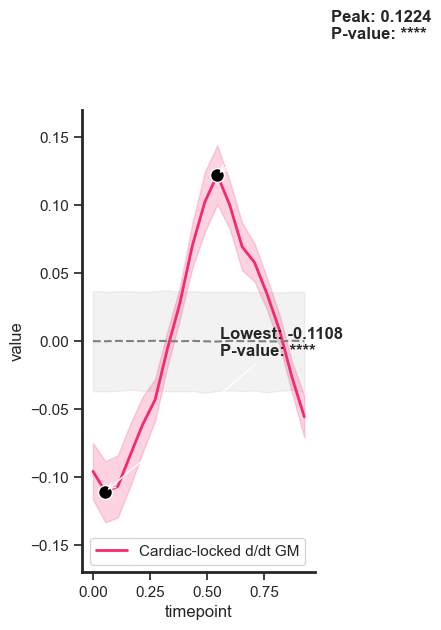

In [9]:
# GM Cardiac
###
# Combine both conditions: PFI
combined_df_gm = pd.concat([long_df_cardiac_gm, long_df_respiration_gm])


first_value = 0

# Shift all values so the first point is at zero
long_df_cardiac_gm["value"] -= first_value

# Now mean the null distribution as well (10.000, 18)
first_value_null = null_cardiac_d_dt_gm.mean(axis=0).iloc[0]
null_cardiac_d_dt_gm = null_cardiac_d_dt_gm - first_value_null
null_mean = np.mean(null_cardiac_d_dt_gm, axis=0)  # Mean over permutations
lower_bound = np.percentile(null_cardiac_d_dt_gm, 2.5, axis=0)  # 2.5th percentile
upper_bound = np.percentile(null_cardiac_d_dt_gm, 97.5, axis=0)  # 97.5th percentile

# Define timepoints (assuming 18 bins), exemplary from subject one
timepoints = long_df_cardiac_gm.loc[long_df_cardiac_gm['measurement'] == 1, 'timepoint']
print(long_df_cardiac_gm)

# Define your figure with 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(figsize=(3, 6))

# Plot using Seaborn

sns.lineplot(
    data=long_df_cardiac_gm,
    x='timepoint',  # Changed from 'subject' to 'timepoint'
    y='value',
    #hue='physiology',
    errorbar='se',  # Shaded region shows standard deviation
    estimator='mean',  # Mean line
    linewidth=2,
    color=(249/255, 38/255, 114/255),  #((171/255, 157/255, 242/255))
    ax=ax,
    label='Cardiac-locked d/dt GM'
)

# Plot null distribution mean with shaded confidence interval
ax.plot(timepoints, null_mean, color="gray", linestyle="dashed", label="Null Mean")
ax.fill_between(timepoints, lower_bound, upper_bound, color="gray", alpha=0.1, label="Null 95% CI")
    
# Now do the statistics - Peak
# Extract peak value and index
mean_gm = long_df_cardiac_gm.groupby("timepoint")["value"].mean()
peak_timepoint = mean_gm.idxmax()  # Get timepoint of the max value
peak_value = mean_gm.max()  # Get the max value itself
time_interval = timepoints[1] - timepoints[0]  # Interval between timepoints
peak_timepoint_index = int(round(peak_timepoint / time_interval))

# Extract observed values at the peak timepoint
observed_values_at_peak = long_df_cardiac_gm.loc[long_df_cardiac_gm['timepoint'] == peak_timepoint, 'value'].values

# Extract null distribution values at the same peak timepoint index
null_values_at_peak = null_cardiac_d_dt_gm.iloc[:, peak_timepoint_index]

print(observed_values_at_peak)
print(observed_values_at_peak.mean())
print(null_values_at_peak)
# Perform Mann-Whitney U test to compare observed values at peak with null values at the same timepoint
stat, p_value = mannwhitneyu(observed_values_at_peak, null_values_at_peak, alternative='two-sided')

# Step 5: Output the p-value
print(f"Mann-Whitney U Test p-value: {p_value}")
# Print formatted p-value or asterisks
if p_value < 0.00001:
    p_value = '****'
else:
    p_value = f'{p_value:.5f}'  # Format the p-value with 5 decimal places

# Mark the peak value with a circle
ax.scatter(peak_timepoint, peak_value, color="black", edgecolor="white", s=100, zorder=3, label="Observed Peak")

# Check if p_value is a string (i.e., '****')
if isinstance(p_value, str):
    annotation_text = f"Peak: {peak_value:.4f}\nP-value: {p_value}"
else:
    annotation_text = f"Peak: {peak_value:.4f}\nP-value: {p_value:.4f}"

# Annotate peak value and p-value
ax.annotate(annotation_text, 
            xy=(peak_timepoint, peak_value), 
            xytext=(peak_timepoint + 0.5, peak_value + 0.1),  # Offset text
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            fontsize=12, weight='bold')


# Now do the statistics - Lowest
# Extract peak value and index
mean_gm = long_df_cardiac_gm.groupby("timepoint")["value"].mean()
peak_timepoint = mean_gm.idxmin()  # Get timepoint of the max value
peak_value = mean_gm.min()  # Get the max value itself
time_interval = timepoints[1] - timepoints[0]  # Interval between timepoints
peak_timepoint_index = int(round(peak_timepoint / time_interval))

# Extract observed values at the peak timepoint
observed_values_at_peak = long_df_cardiac_gm.loc[long_df_cardiac_gm['timepoint'] == peak_timepoint, 'value'].values

# Extract null distribution values at the same peak timepoint index
null_values_at_peak = null_cardiac_d_dt_gm.iloc[:, peak_timepoint_index]

print(observed_values_at_peak)
print(observed_values_at_peak.mean())
print(null_values_at_peak)
# Perform Mann-Whitney U test to compare observed values at peak with null values at the same timepoint
stat, p_value = mannwhitneyu(observed_values_at_peak, null_values_at_peak, alternative='two-sided')

# Step 5: Output the p-value
print(f"Mann-Whitney U Test p-value: {p_value}")
# Print formatted p-value or asterisks
if p_value < 0.00001:
    p_value = '****'
else:
    p_value = f'{p_value:.5f}'  # Format the p-value with 5 decimal places

# Mark the peak value with a circle
ax.scatter(peak_timepoint, peak_value, color="black", edgecolor="white", s=100, zorder=3, label="Observed Peak")

# Check if p_value is a string (i.e., '****')
if isinstance(p_value, str):
    annotation_text = f"Lowest: {peak_value:.4f}\nP-value: {p_value}"
else:
    annotation_text = f"Lowest: {peak_value:.4f}\nP-value: {p_value:.4f}"

# Annotate peak value and p-value
ax.annotate(annotation_text, 
            xy=(peak_timepoint, peak_value), 
            xytext=(peak_timepoint + 0.5, peak_value + 0.1),  # Offset text
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            fontsize=12, weight='bold')

plt.ylim(-0.17, 0.17)

sns.despine()


# Save the figure -------
#image_path = os.path.join(outDir, f'GM_cardiac.png')
#fig.savefig(image_path,dpi=600, bbox_inches='tight')
#---
#image_path_svg = os.path.join(outDir, f'GM_cardiac.svg')
#fig.savefig(image_path_svg)



# ==============================================================
# Amplitude Test: Observed (peak - trough) vs Null Distribution
# ==============================================================


# Each row is one permutation → amplitude = max - min across bins
null_amplitudes = null_cardiac_d_dt_gm.max(axis=1) - null_cardiac_d_dt_gm.min(axis=1)

print(f"Computed {len(null_amplitudes)} null amplitudes")
print(f"Example null amplitudes: {null_amplitudes[:10]}")
print(f"Mean null amplitude: {null_amplitudes.mean():.4f}")

# Subject amplitudes: max-min per subject trace
subject_amplitudes = (
    long_df_cardiac_gm.groupby("measurement")["value"].apply(lambda x: x.max() - x.min())
)

print("Subject amplitudes:")
print(subject_amplitudes.values)

# Mann–Whitney U: compares subject amplitude distribution vs null
stat, p_value_subjects = mannwhitneyu(subject_amplitudes, null_amplitudes, alternative="two-sided")

print(f"Median subject amplitude: {subject_amplitudes.median():.4f}")
print(f"Mean null amplitude: {null_amplitudes.mean():.4f}")
print(f"Mann-Whitney U p-value: {p_value_subjects:.5f}")



# Panel 5D

-2
One-sample t-test at lag -2: t = -9.928, p = 0.00000
-0.7348769121775174
0.2668778371275388


/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_6550/1163722857.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_lags_at_min_corr = pd.concat([df_lags_at_min_corr, pd.DataFrame({'subject': [subject], 'min_corr_lag': [min_corr_lag]})], ignore_index=True)


Text(0.5, 1.0, 'Mean Phase Shift between GM and PFI')

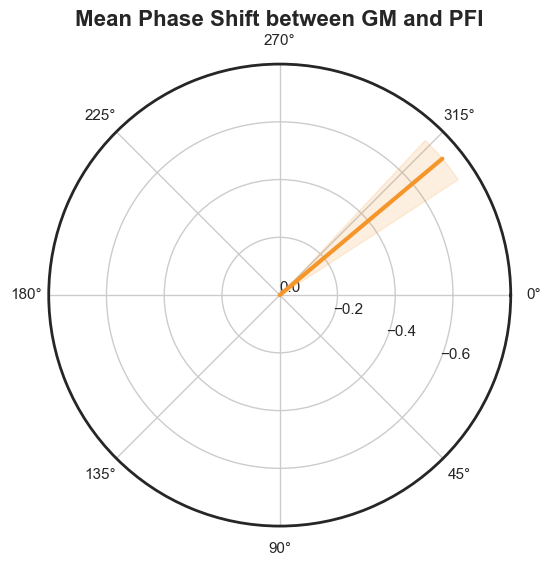

In [10]:
# Ensure dataframes are sorted by subject and timepoint
df_gm = long_df_cardiac_gm.sort_values(by=['measurement', 'timepoint'])
df_pfi = long_df_cardiac_pfi.sort_values(by=['measurement', 'timepoint'])

# Get unique subjects (ensure integer formatting)
subjects = df_pfi['measurement'].unique()
subjects = np.sort(subjects)  # Ensure proper order

# Store cross-correlation results
df_xcorr = pd.DataFrame()

# Store lags at max correlation for each subject
df_lags_at_min_corr = pd.DataFrame(columns=['subject', 'min_corr_lag'])

for subject in subjects:
    # Extract subject-specific timecourses
    gm_values = df_gm[df_gm['measurement'] == subject].pivot(index="timepoint", columns="measurement", values="value")
    pfi_values = df_pfi[df_pfi['measurement'] == subject].pivot(index="timepoint", columns="measurement", values="value")

    #print(pfi_values)

    # Ensure both signals are aligned (use common timepoints)
    common_timepoints = gm_values.index.intersection(pfi_values.index)
    gm_values = gm_values.loc[common_timepoints].mean(axis=1)  # Average over measurements
    pfi_values = pfi_values.loc[common_timepoints].mean(axis=1)  # Average over measurements

    #print(pfi_values)

    # Normalize the pfi_values and csf_values
    norm_gm = np.linalg.norm(gm_values)
    gm_values = gm_values / norm_gm

    norm_pfi = np.linalg.norm(pfi_values)
    pfi_values = pfi_values / norm_pfi

    # Compute cross-correlation using SciPy
    corr_values = correlate(gm_values, pfi_values, mode='full', method='auto')
    lags = np.arange(-len(common_timepoints) + 1, len(common_timepoints))  # Corresponding lag times


    # Find the lag with the maximum correlation for the subject
    min_corr_idx = np.argmin(corr_values) # We were searching for max before, but this should be min between GM and PFI
    min_corr_lag = lags[min_corr_idx]  # Lag of max correlation

    # Store the max correlation lag for this subject
    df_lags_at_min_corr = pd.concat([df_lags_at_min_corr, pd.DataFrame({'subject': [subject], 'min_corr_lag': [min_corr_lag]})], ignore_index=True)

    # Store results in DataFrame
    temp_df = pd.DataFrame({'subject': subject, 'lag': lags, 'correlation': corr_values})
    df_xcorr = pd.concat([df_xcorr, temp_df], ignore_index=True)



# Compute mean cross-correlation over subjects
df_mean_xcorr = df_xcorr.groupby('lag')['correlation'].mean().reset_index()

# Compute the SEM of the lags at max correlation across all subjects
df_lags_sem = df_lags_at_min_corr['min_corr_lag'].sem()

# Find the lag corresponding to the maximum mean correlation
min_corr_idx = df_mean_xcorr['correlation'].idxmin()  # Index of max correlation
min_corr_value = df_mean_xcorr.loc[min_corr_idx, 'correlation']  # Maximum correlation value
min_corr_lag = df_mean_xcorr.loc[min_corr_idx, 'lag']  # Lag corresponding to max correlation

#print(df_mean_xcorr)
print(min_corr_lag)

#-----
# Add test whether different from zero at the lag:
# Define the lag of interest
target_lag = min_corr_lag

# Extract all individual correlation values at lag = -2
corr_at_lag = df_xcorr[df_xcorr['lag'] == target_lag]['correlation']

# Perform one-sample t-test against 0
t_stat, p_val = stats.ttest_1samp(corr_at_lag, 0)

print(f"One-sample t-test at lag {target_lag}: t = {t_stat:.3f}, p = {p_val:.5f}")
print(corr_at_lag.mean())
print(corr_at_lag.std())
#-------



# Now compute the SEM for the lags at the maximum correlation value in the non-meaned dataframe
df_lag_sem = df_xcorr[df_xcorr['lag'] == min_corr_lag].groupby('lag')['correlation'].sem().reset_index()

# Convert lag of max correlation to angle
min_angle = np.radians(min_corr_lag * (360 / len(common_timepoints)))

# Convert time shift to phase shift
cycle_length = max(common_timepoints) - min(common_timepoints)  # Full cycle duration
#mean_phase_shift = (max_shift_seconds / cycle_length) * 360  # Convert to degrees

# Create Polar Plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))

# Convert lags to angles
angles = np.radians(df_mean_xcorr['lag'] * (360 / len(common_timepoints)))


# Plot the maximum correlation at its corresponding lag
ax.plot([min_angle, min_angle], [0, min_corr_value], color=((244/255, 150/255, 42/255)), label="Min Correlation", linewidth=3) #((171/255, 157/255, 242/255))

#print(max_corr_value)
#print(min_corr_lag)
#print(len(common_timepoints))

# Convert SEM of the lags into angle space
sem_angle = np.radians(df_lags_sem * (360 / len(common_timepoints)))

# Create an angle range with smooth edges for SEM
angles_range = np.linspace(min_angle - sem_angle, min_angle + sem_angle, 100)

# Define the SEM height, scaled to match the max_corr_value
sem_y_values = np.full_like(angles_range, min_corr_value)  # Create an array filled with max_corr_value

# Now add SEM shading smoothly to the plot
ax.fill_between(angles_range, 0, sem_y_values, 
                color=((244/255, 150/255, 42/255)), alpha=0.15, label="SEM at Min Correlation Lags") #((171/255, 157/255, 242/255))"""



# Format plot
#ax.set_rticks([])  # Hide radial ticks
ax.set_theta_zero_location("E")  # Set 0° to the right
ax.set_theta_direction(-1)  # Set direction to counterclockwise
# Set y-axis range from 0 to 1 and show ticks
ax.set_ylim(0, -0.8)  # Set y-axis range
ax.set_yticks([0, -0.2, -0.4, -0.6])  # Customize radial ticks to show scale from 0 to 1
ax.set_title("Mean Phase Shift between GM and PFI", fontsize=16, weight='bold')



# Panel 5E

[ 6.5952423  26.67535148 -4.61410562 10.04013833 14.12518437 20.94743721
  2.9732048   1.61798906  2.50106777 -1.63352866 23.66128502 14.28036488
 -3.55087296]
8.739904459961888
0      -0.568800
1       2.323750
2       1.429312
3       0.467920
4       1.588304
          ...   
9994   -2.166227
9995   -2.191553
9996   -1.146284
9997   -1.672745
9998    1.806541
Name: -0.38991384490465153, Length: 9999, dtype: float64
Mann-Whitney U Test p-value: 0.0012148499832814698
[ -9.73444974 -18.34968592 -11.57168407  -9.42453916 -11.53978115
  -3.27506576   0.86795234   1.16619328   0.91867725  -3.57569369
 -13.68385229 -10.70095288  -0.30375356]
-6.8620488723260085
0       2.910537
1      -1.360934
2      -0.249458
3      -0.171068
4       2.257174
          ...   
9994   -0.848607
9995    1.057494
9996    0.547273
9997    1.657000
9998    0.103931
Name: 0.3134943778989392, Length: 9999, dtype: float64
Mann-Whitney U Test p-value: 0.00018903941200237043
Computed 9999 null amplitudes
Example nu

/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_6550/3154635644.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  offset = np.trapz(mean_signal, dx=1) / len(mean_signal)


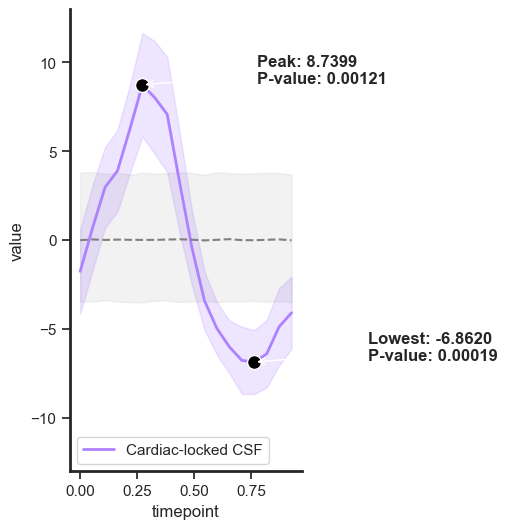

In [11]:
# Compute the offset for oscillation correction
# Compute the mean across timepoints
mean_signal = long_df_cardiac_csf.groupby("timepoint")["value"].mean()

# Estimate area under the curve (AUC) using trapezoidal integration
# (Assumes timepoints are uniformly spaced)
offset = np.trapz(mean_signal, dx=1) / len(mean_signal)

# Subtract the offset from all values to center integral at zero
long_df_cardiac_csf["value"] -= offset


# Now mean the null distribution as well (10.000, 18)
first_value_null = null_cardiac_csf.mean(axis=0).iloc[0]
null_cardiac_csf = null_cardiac_csf - first_value_null
null_mean = np.mean(null_cardiac_csf, axis=0)  # Mean over permutations
lower_bound = np.percentile(null_cardiac_csf, 2.5, axis=0)  # 2.5th percentile
upper_bound = np.percentile(null_cardiac_csf, 97.5, axis=0)  # 97.5th percentile

# Define timepoints (assuming 18 bins), exemplary from subject one
timepoints = long_df_cardiac_csf.loc[long_df_cardiac_csf['measurement'] == 1, 'timepoint']


# Define your figure with 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(figsize=(3,6))


# Plot using Seaborn

sns.lineplot(
    data=long_df_cardiac_csf,
    x='timepoint',  # Changed from 'subject' to 'timepoint'
    y='value',
    #hue='physiology',
    errorbar='se',  # Shaded region shows standard deviation
    estimator='mean',  # Mean line
    linewidth=2,
    color=(174/255, 129/255, 255/255),  #((171/255, 157/255, 242/255))
    ax=ax,
    label='Cardiac-locked CSF'
)

# Plot null distribution mean with shaded confidence interval
ax.plot(timepoints, null_mean, color="gray", linestyle="dashed", label="Null Mean")
ax.fill_between(timepoints, lower_bound, upper_bound, color="gray", alpha=0.1, label="Null 95% CI")
    
# Now do the statistics - Peak
# Extract peak value and index
mean_pfi = long_df_cardiac_csf.groupby("timepoint")["value"].mean()
peak_timepoint = mean_pfi.idxmax()  # Get timepoint of the max value
peak_value = mean_pfi.max()  # Get the max value itself
time_interval = timepoints[1] - timepoints[0]  # Interval between timepoints
peak_timepoint_index = int(round(peak_timepoint / time_interval))

# Extract observed values at the peak timepoint
observed_values_at_peak = long_df_cardiac_csf.loc[long_df_cardiac_csf['timepoint'] == peak_timepoint, 'value'].values

# Extract null distribution values at the same peak timepoint index
null_values_at_peak = null_cardiac_csf.iloc[:, peak_timepoint_index]

print(observed_values_at_peak)
print(observed_values_at_peak.mean())
print(null_values_at_peak)
# Perform Mann-Whitney U test to compare observed values at peak with null values at the same timepoint
stat, p_value = mannwhitneyu(observed_values_at_peak, null_values_at_peak, alternative='two-sided')

# Step 5: Output the p-value
print(f"Mann-Whitney U Test p-value: {p_value}")
# Print formatted p-value or asterisks
if p_value < 0.00001:
    p_value = '****'
else:
    p_value = f'{p_value:.5f}'  # Format the p-value with 5 decimal places

# Mark the peak value with a circle
ax.scatter(peak_timepoint, peak_value, color="black", edgecolor="white", s=100, zorder=3, label="Observed Peak")

# Check if p_value is a string (i.e., '****')
if isinstance(p_value, str):
    annotation_text = f"Peak: {peak_value:.4f}\nP-value: {p_value}"
else:
    annotation_text = f"Peak: {peak_value:.4f}\nP-value: {p_value:.4f}"

# Annotate peak value and p-value
ax.annotate(annotation_text, 
            xy=(peak_timepoint, peak_value), 
            xytext=(peak_timepoint + 0.5, peak_value + 0.1),  # Offset text
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            fontsize=12, weight='bold')


# Now do the statistics - Lowest
# Extract peak value and index
mean_pfi = long_df_cardiac_csf.groupby("timepoint")["value"].mean()
peak_timepoint = mean_pfi.idxmin()  # Get timepoint of the max value
peak_value = mean_pfi.min()  # Get the max value itself
time_interval = timepoints[1] - timepoints[0]  # Interval between timepoints
peak_timepoint_index = int(round(peak_timepoint / time_interval))

# Extract observed values at the peak timepoint
observed_values_at_peak = long_df_cardiac_csf.loc[long_df_cardiac_csf['timepoint'] == peak_timepoint, 'value'].values

# Extract null distribution values at the same peak timepoint index
null_values_at_peak = null_cardiac_csf.iloc[:, peak_timepoint_index]

print(observed_values_at_peak)
print(observed_values_at_peak.mean())
print(null_values_at_peak)
# Perform Mann-Whitney U test to compare observed values at peak with null values at the same timepoint
stat, p_value = mannwhitneyu(observed_values_at_peak, null_values_at_peak, alternative='two-sided')

# Step 5: Output the p-value
print(f"Mann-Whitney U Test p-value: {p_value}")
# Print formatted p-value or asterisks
if p_value < 0.00001:
    p_value = '****'
else:
    p_value = f'{p_value:.5f}'  # Format the p-value with 5 decimal places

# Mark the peak value with a circle
ax.scatter(peak_timepoint, peak_value, color="black", edgecolor="white", s=100, zorder=3, label="Observed Lowest")

# Check if p_value is a string (i.e., '****')
if isinstance(p_value, str):
    annotation_text = f"Lowest: {peak_value:.4f}\nP-value: {p_value}"
else:
    annotation_text = f"Lowest: {peak_value:.4f}\nP-value: {p_value:.4f}"

# Annotate peak value and p-value
ax.annotate(annotation_text, 
            xy=(peak_timepoint, peak_value), 
            xytext=(peak_timepoint + 0.5, peak_value + 0.1),  # Offset text
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            fontsize=12, weight='bold')

sns.despine()

plt.ylim(-13,13)

# Save the figure -------
#image_path = os.path.join(outDir, f'CSF_cardiac.png')
#fig.savefig(image_path,dpi=600, bbox_inches='tight')
#---
#image_path_svg = os.path.join(outDir, f'CSF_cardiac.svg')
#fig.savefig(image_path_svg)


# ==============================================================
# Amplitude Test: Observed (peak - trough) vs Null Distribution
# ==============================================================

# Each row is one permutation → amplitude = max - min across bins
null_amplitudes = null_cardiac_csf.max(axis=1) - null_cardiac_csf.min(axis=1)

print(f"Computed {len(null_amplitudes)} null amplitudes")
print(f"Example null amplitudes: {null_amplitudes[:10]}")
print(f"Mean null amplitude: {null_amplitudes.mean():.4f}")

# Subject amplitudes: max-min per subject trace
subject_amplitudes = (
    long_df_cardiac_csf.groupby("measurement")["value"].apply(lambda x: x.max() - x.min())
)

print("Subject amplitudes:")
print(subject_amplitudes.values)

# Mann–Whitney U: compares subject amplitude distribution vs null
stat, p_value_subjects = mannwhitneyu(subject_amplitudes, null_amplitudes, alternative="two-sided")

print(f"Median subject amplitude: {subject_amplitudes.median():.4f}")
print(f"Mean null amplitude: {null_amplitudes.mean():.4f}")
print(f"Mann-Whitney U p-value: {p_value_subjects:.5f}")

# Panel 5F


/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_6550/1526085993.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_lags_at_max_corr = pd.concat([df_lags_at_max_corr, pd.DataFrame({'subject': [subject], 'max_corr_lag': [max_corr_lag]})], ignore_index=True)


0
One-sample t-test at lag 0: t = 9.010, p = 0.00000
0.6354686910907984
0.25430383964965797


Text(0.5, 1.0, 'Mean Phase Shift between PFI and CSF')

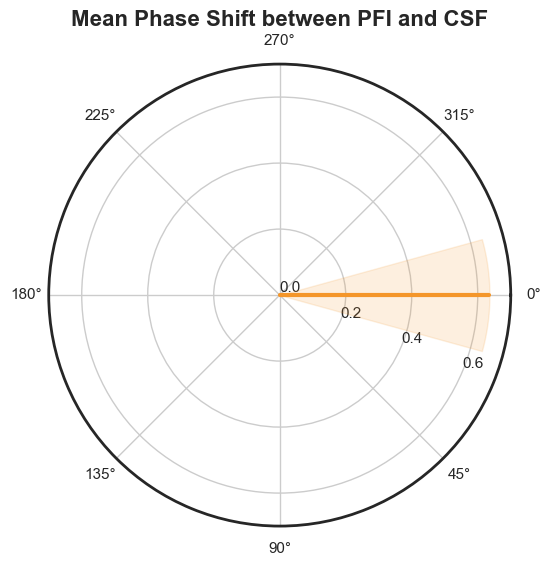

In [12]:

# Ensure dataframes are sorted by subject and timepoint
df_pfi = long_df_cardiac_pfi.sort_values(by=['measurement', 'timepoint'])
df_csf = long_df_cardiac_csf.sort_values(by=['measurement', 'timepoint'])

# Get unique subjects (ensure integer formatting)
subjects = df_pfi['measurement'].unique()
subjects = np.sort(subjects)  # Ensure proper order

# Store cross-correlation results
df_xcorr = pd.DataFrame()

# Store lags at max correlation for each subject
df_lags_at_max_corr = pd.DataFrame(columns=['subject', 'max_corr_lag'])

for subject in subjects:
    # Extract subject-specific timecourses
    pfi_values = df_pfi[df_pfi['measurement'] == subject].pivot(index="timepoint", columns="measurement", values="value")
    csf_values = df_csf[df_csf['measurement'] == subject].pivot(index="timepoint", columns="measurement", values="value")

    #print(pfi_values)

    # Ensure both signals are aligned (use common timepoints)
    common_timepoints = pfi_values.index.intersection(csf_values.index)
    pfi_values = pfi_values.loc[common_timepoints].mean(axis=1)  # Average over measurements
    csf_values = csf_values.loc[common_timepoints].mean(axis=1)  # Average over measurements

    #print(pfi_values)

    # Normalize the pfi_values and csf_values
    norm_pfi = np.linalg.norm(pfi_values)
    pfi_values = pfi_values / norm_pfi

    norm_csf = np.linalg.norm(csf_values)
    csf_values = csf_values / norm_csf

    # Compute cross-correlation using SciPy
    corr_values = correlate(pfi_values, csf_values, mode='full', method='auto')
    lags = np.arange(-len(common_timepoints) + 1, len(common_timepoints))  # Corresponding lag times

    # Normalize the cross-correlation values per subject
    #corr_values /= (np.std(pfi_values) * np.std(csf_values) * len(common_timepoints))
    # Find the lag with the maximum correlation for the subject
    max_corr_idx = np.argmax(corr_values)
    max_corr_lag = lags[max_corr_idx]  # Lag of max correlation

    # Store the max correlation lag for this subject
    df_lags_at_max_corr = pd.concat([df_lags_at_max_corr, pd.DataFrame({'subject': [subject], 'max_corr_lag': [max_corr_lag]})], ignore_index=True)

    # Store results in DataFrame
    temp_df = pd.DataFrame({'subject': subject, 'lag': lags, 'correlation': corr_values})
    df_xcorr = pd.concat([df_xcorr, temp_df], ignore_index=True)

#print(df_xcorr)

# Compute mean cross-correlation over subjects
df_mean_xcorr = df_xcorr.groupby('lag')['correlation'].mean().reset_index()


# Compute the SEM:
# Compute the SEM of the lags at max correlation across all subjects
df_lags_sem = df_lags_at_max_corr['max_corr_lag'].sem()

# Find the lag corresponding to the maximum mean correlation
max_corr_idx = df_mean_xcorr['correlation'].idxmax()  # Index of max correlation
max_corr_value = df_mean_xcorr.loc[max_corr_idx, 'correlation']  # Maximum correlation value
max_corr_lag = df_mean_xcorr.loc[max_corr_idx, 'lag']  # Lag corresponding to max correlation

print(max_corr_lag)
#-----
# Add test whether different from zero at the lag:
# Define the lag of interest
target_lag = max_corr_lag

# Extract all individual correlation values at lag = -2
corr_at_lag = df_xcorr[df_xcorr['lag'] == target_lag]['correlation']

# Perform one-sample t-test against 0
t_stat, p_val = stats.ttest_1samp(corr_at_lag, 0)

print(f"One-sample t-test at lag {target_lag}: t = {t_stat:.3f}, p = {p_val:.5f}")
print(corr_at_lag.mean())
print(corr_at_lag.std())
#-------


# Now compute the SEM for the lags at the maximum correlation value in the non-meaned dataframe
df_lag_sem = df_xcorr[df_xcorr['lag'] == max_corr_lag].groupby('lag')['correlation'].sem().reset_index()

# Convert lag of max correlation to angle
max_angle = np.radians(max_corr_lag * (360 / len(common_timepoints)))

# Convert time shift to phase shift
cycle_length = max(common_timepoints) - min(common_timepoints)  # Full cycle duration
#mean_phase_shift = (max_shift_seconds / cycle_length) * 360  # Convert to degrees"""

# Create Polar Plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))

# Convert lags to angles
angles = np.radians(df_mean_xcorr['lag'] * (360 / len(common_timepoints)))


# Plot the maximum correlation at its corresponding lag
ax.plot([max_angle, max_angle], [0, max_corr_value], color=((244/255, 150/255, 42/255)), label="Max Correlation", linewidth=3) #((171/255, 157/255, 242/255))

#print(max_corr_value)
#print(max_corr_lag)
#print(len(common_timepoints))

# Convert SEM of the lags into angle space
sem_angle = np.radians(df_lags_sem * (360 / len(common_timepoints)))

# Create an angle range with smooth edges for SEM
angles_range = np.linspace(max_angle - sem_angle, max_angle + sem_angle, 100)

# Define the SEM height, scaled to match the max_corr_value
sem_y_values = np.full_like(angles_range, max_corr_value)  # Create an array filled with max_corr_value

# Now add SEM shading smoothly to the plot
ax.fill_between(angles_range, 0, sem_y_values, 
                color=((244/255, 150/255, 42/255)), alpha=0.15, label="SEM at Max Correlation Lags") #((171/255, 157/255, 242/255))"""



# Format plot

ax.set_theta_zero_location("E")  # Set 0° to the right
ax.set_theta_direction(-1)  # Set direction to counterclockwise
# Set y-axis range from 0 to 1 and show ticks
ax.set_ylim(0, 0.7)  # Set y-axis range
ax.set_yticks([0, 0.2, 0.4, 0.6])  # Customize radial ticks to show scale from 0 to 1
ax.set_title("Mean Phase Shift between PFI and CSF", fontsize=16, weight='bold')






# Panel 5G

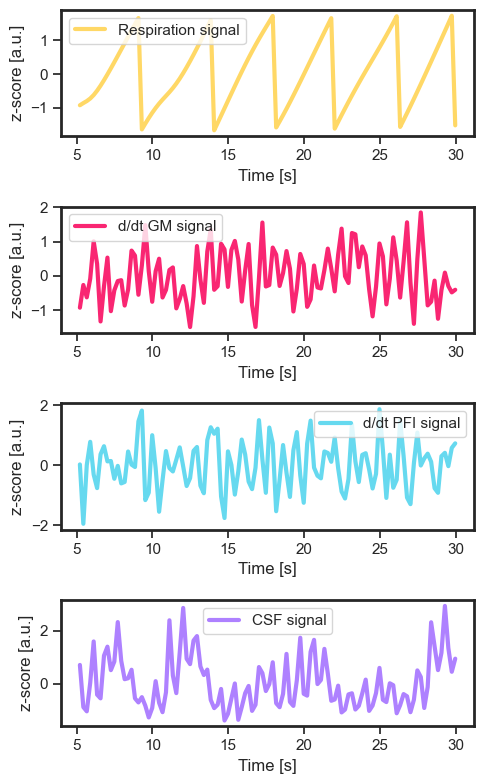

<Figure size 640x480 with 0 Axes>

In [13]:

ex_timecourse = respiration_timecourse


# Extract the timecourses for the specific subject
Subject = pd.DataFrame()
Subject['time'] = ex_timecourse.iloc[:,0]
Subject['cardiac'] = stats.zscore(ex_timecourse.iloc[:,1])
Subject['respiration'] = stats.zscore(ex_timecourse.iloc[:,2])
Subject['pfi'] = stats.zscore(ex_timecourse.iloc[:,3])
Subject['csf'] = stats.zscore(ex_timecourse.iloc[:,4])
Subject['gm'] = stats.zscore(ex_timecourse.iloc[:,5])

# Display the new DataFrame
#print(Subject)
Subject_short = Subject[(Subject['time'] >= 5) & (Subject['time'] <= 30)]

# Create a figure with 4 subplots stacked vertically
fig, axs = plt.subplots(4, 1, figsize=(5,8))


sns.lineplot(x="time", y='respiration', data=Subject_short, ax=axs[0], label='Respiration signal', color=((255/255, 216/255, 102/255)), linewidth=3, legend=True)
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('z-score [a.u.]')


sns.lineplot(x="time", y='pfi', data=Subject_short, ax=axs[2], label='d/dt PFI signal', color=(102/255, 217/255, 239/255), linewidth=3, legend=True)
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('z-score [a.u.]')


sns.lineplot(x="time", y='csf', data=Subject_short, ax=axs[3], label='CSF signal', color=(174/255, 129/255, 255/255), linewidth=3, legend=True)
axs[3].set_xlabel('Time [s]')
axs[3].set_ylabel('z-score [a.u.]')

sns.lineplot(x="time", y='gm', data=Subject_short, ax=axs[1], label='d/dt GM signal', color=(249/255, 38/255, 114/255), linewidth=3, legend=True)
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('z-score [a.u.]')

# Adjust layout for better spacing
plt.tight_layout()


# Show the plot
plt.show()

#fig.legend(loc='lower right')
sns.despine(right=True, left=True)



# Save the figure -------
#image_path = os.path.join(outDir, f'Physiology_tc_sub-05-11.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Physiology_tc_sub-05-11.svg')
#fig.savefig(image_path_svg, transparent=True)

# Panel 5H

[ 0.05207539  0.65638748  0.01429935 -0.05735014  0.49575102 -0.03428212
  0.35756644  0.09636593  0.47831239  0.05697221 -0.02730562  0.10193228
 -0.05527615]
0       0.037109
1       0.003633
2       0.001957
3      -0.030332
4       0.013628
          ...   
9994    0.023433
9995    0.048358
9996    0.057009
9997    0.011044
9998   -0.005024
Name: 0.005529799659082833, Length: 9999, dtype: float64
Mann-Whitney U Test p-value: 0.018596148975120425
[ 0.05207539  0.65638748  0.01429935 -0.05735014  0.49575102 -0.03428212
  0.35756644  0.09636593  0.47831239  0.05697221 -0.02730562  0.10193228
 -0.05527615]
0.1642652659662121
0       0.037109
1       0.003633
2       0.001957
3      -0.030332
4       0.013628
          ...   
9994    0.023433
9995    0.048358
9996    0.057009
9997    0.011044
9998   -0.005024
Name: 0.005529799659082833, Length: 9999, dtype: float64
Mann-Whitney U Test p-value: 0.018596148975120425
[ 0.0028026  -0.15348796 -0.0250926   0.10710808 -0.19594648 -0.06762257


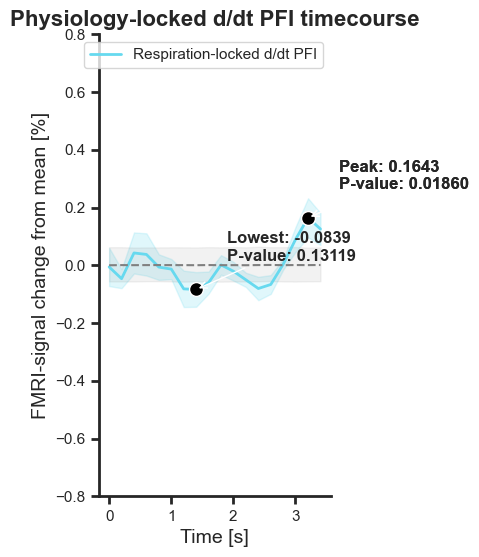

Computed 9999 null amplitudes
Example null amplitudes: 0    0.107893
1    0.104373
2    0.129693
3    0.118720
4    0.105551
5    0.145911
6    0.138140
7    0.114576
8    0.135774
9    0.091659
dtype: float64
Mean null amplitude: 0.1129
Subject amplitudes:
[0.29853851 0.99592747 0.10778499 0.40742736 0.6916975  0.34712286
 1.61313121 0.43292963 0.85613359 0.28347341 0.24589533 0.30649097
 0.25227215]
Median subject amplitude: 0.3471
Mean null amplitude: 0.1129
Mann-Whitney U p-value: 0.00000


In [14]:

first_value = 0
# Shift all values so the first point is at zero
long_df_respiration_pfi["value"] -= first_value

# Now mean the null distribution as well (10.000, 18)
first_value_null = null_respiration_d_dt_pfi.mean(axis=0).iloc[0]
null_respiration_d_dt_pfi = null_respiration_d_dt_pfi - first_value_null
null_mean = np.mean(null_respiration_d_dt_pfi, axis=0)  # Mean over permutations
lower_bound = np.percentile(null_respiration_d_dt_pfi, 2.5, axis=0)  # 2.5th percentile
upper_bound = np.percentile(null_respiration_d_dt_pfi, 97.5, axis=0)  # 97.5th percentile

# Define timepoints (assuming 18 bins), exemplary from subject one
timepoints = long_df_respiration_pfi.loc[long_df_respiration_pfi['measurement'] == 1, 'timepoint']

# Plot using Seaborn
fig, ax = plt.subplots(figsize=(3, 6))
sns.lineplot(
    data=long_df_respiration_pfi,
    x='timepoint',  # Changed from 'subject' to 'timepoint'
    y='value',
    #hue='physiology',
    errorbar='se',  # Shaded region shows standard error
    estimator='mean',  # Mean line
    linewidth=2,
    color=(102/255, 217/255, 239/255),  # Reddish for other data
    ax=ax,
    label='Respiration-locked d/dt PFI'
)

# Plot null distribution mean with shaded confidence interval
ax.plot(timepoints, null_mean, color="gray", linestyle="dashed", label="Null Mean")
ax.fill_between(timepoints, lower_bound, upper_bound, color="gray", alpha=0.1, label="Null 95% CI")
    
# Now do the statistics - Peak
# Extract peak value and index
mean_pfi = long_df_respiration_pfi.groupby("timepoint")["value"].mean()
peak_timepoint = mean_pfi.idxmax()  # Get timepoint of the max value
peak_value = mean_pfi.max()  # Get the max value itself
time_interval = timepoints[1] - timepoints[0]  # Interval between timepoints
peak_timepoint_index = int(round(peak_timepoint / time_interval))

# Extract observed values at the peak timepoint
observed_values_at_peak = long_df_respiration_pfi.loc[long_df_respiration_pfi['timepoint'] == peak_timepoint, 'value'].values

# Extract null distribution values at the same peak timepoint index
null_values_at_peak = null_respiration_d_dt_pfi.iloc[:, peak_timepoint_index]

print(observed_values_at_peak)
print(null_values_at_peak)
# Perform Mann-Whitney U test to compare observed values at peak with null values at the same timepoint
stat, p_value = mannwhitneyu(observed_values_at_peak, null_values_at_peak, alternative='two-sided')

# Step 5: Output the p-value
print(f"Mann-Whitney U Test p-value: {p_value}")
# Print formatted p-value or asterisks
if p_value < 0.00001:
    p_value = '****'
else:
    p_value = f'{p_value:.5f}'  # Format the p-value with 5 decimal places

# Mark the peak value with a circle
ax.scatter(peak_timepoint, peak_value, color="black", edgecolor="white", s=100, zorder=3, label="Observed Peak")

# Check if p_value is a string (i.e., '****')
if isinstance(p_value, str):
    annotation_text = f"Peak: {peak_value:.4f}\nP-value: {p_value}"
else:
    annotation_text = f"Peak: {peak_value:.4f}\nP-value: {p_value:.4f}"

# Annotate peak value and p-value
ax.annotate(annotation_text, 
            xy=(peak_timepoint, peak_value), 
            xytext=(peak_timepoint + 0.5, peak_value + 0.1),  # Offset text
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            fontsize=12, weight='bold')

# Now do the statistics - Peak
# Extract peak value and index
mean_pfi = long_df_respiration_pfi.groupby("timepoint")["value"].mean()
peak_timepoint = mean_pfi.idxmax()  # Get timepoint of the max value
peak_value = mean_pfi.max()  # Get the max value itself
time_interval = timepoints[1] - timepoints[0]  # Interval between timepoints
peak_timepoint_index = int(round(peak_timepoint / time_interval))

# Extract observed values at the peak timepoint
observed_values_at_peak = long_df_respiration_pfi.loc[long_df_respiration_pfi['timepoint'] == peak_timepoint, 'value'].values

# Extract null distribution values at the same peak timepoint index
null_values_at_peak = null_respiration_d_dt_pfi.iloc[:, peak_timepoint_index]

print(observed_values_at_peak)
print(observed_values_at_peak.mean())
print(null_values_at_peak)
# Perform Mann-Whitney U test to compare observed values at peak with null values at the same timepoint
stat, p_value = mannwhitneyu(observed_values_at_peak, null_values_at_peak, alternative='two-sided')

# Step 5: Output the p-value
print(f"Mann-Whitney U Test p-value: {p_value}")
# Print formatted p-value or asterisks
if p_value < 0.00001:
    p_value = '****'
else:
    p_value = f'{p_value:.5f}'  # Format the p-value with 5 decimal places

# Mark the peak value with a circle
ax.scatter(peak_timepoint, peak_value, color="black", edgecolor="white", s=100, zorder=3, label="Observed Peak")

# Check if p_value is a string (i.e., '****')
if isinstance(p_value, str):
    annotation_text = f"Peak: {peak_value:.4f}\nP-value: {p_value}"
else:
    annotation_text = f"Peak: {peak_value:.4f}\nP-value: {p_value:.4f}"

# Annotate peak value and p-value
ax.annotate(annotation_text, 
            xy=(peak_timepoint, peak_value), 
            xytext=(peak_timepoint + 0.5, peak_value + 0.1),  # Offset text
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            fontsize=12, weight='bold')

# Now do the statistics - Lowest
# Extract peak value and index
mean_pfi = long_df_respiration_pfi.groupby("timepoint")["value"].mean()
peak_timepoint = mean_pfi.idxmin()  # Get timepoint of the max value
peak_value = mean_pfi.min()  # Get the max value itself
time_interval = timepoints[1] - timepoints[0]  # Interval between timepoints
peak_timepoint_index = int(round(peak_timepoint / time_interval))

# Extract observed values at the peak timepoint
observed_values_at_peak = long_df_respiration_pfi.loc[long_df_respiration_pfi['timepoint'] == peak_timepoint, 'value'].values

# Extract null distribution values at the same peak timepoint index
null_values_at_peak = null_respiration_d_dt_pfi.iloc[:, peak_timepoint_index]

print(observed_values_at_peak)
print(observed_values_at_peak.mean())
print(null_values_at_peak)
# Perform Mann-Whitney U test to compare observed values at peak with null values at the same timepoint
stat, p_value = mannwhitneyu(observed_values_at_peak, null_values_at_peak, alternative='two-sided')

# Step 5: Output the p-value
print(f"Mann-Whitney U Test p-value: {p_value}")
# Print formatted p-value or asterisks
if p_value < 0.00001:
    p_value = '****'
else:
    p_value = f'{p_value:.5f}'  # Format the p-value with 5 decimal places

# Mark the peak value with a circle
ax.scatter(peak_timepoint, peak_value, color="black", edgecolor="white", s=100, zorder=3, label="Observed Lowest")

# Check if p_value is a string (i.e., '****')
if isinstance(p_value, str):
    annotation_text = f"Lowest: {peak_value:.4f}\nP-value: {p_value}"
else:
    annotation_text = f"Lowest: {peak_value:.4f}\nP-value: {p_value:.4f}"

# Annotate peak value and p-value
ax.annotate(annotation_text, 
            xy=(peak_timepoint, peak_value), 
            xytext=(peak_timepoint + 0.5, peak_value + 0.1),  # Offset text
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            fontsize=12, weight='bold')



plt.title(f"Physiology-locked d/dt PFI timecourse", fontsize=16, weight='bold')
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('FMRI-signal change from mean [%]', fontsize=14)
ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
for spine in ax.spines.values():
    spine.set_linewidth(2)

sns.despine()
plt.ylim(-0.8,0.8)
plt.show()

# Save the figure -------
#image_path = os.path.join(outDir, f'PFI_respiration.png')
#fig.savefig(image_path,dpi=600, bbox_inches='tight')
#---
#image_path_svg = os.path.join(outDir, f'PFI_respiration.svg')
#fig.savefig(image_path_svg)

# ==============================================================
# Amplitude Test: Observed (peak - trough) vs Null Distribution
# ==============================================================

# Each row is one permutation → amplitude = max - min across bins
null_amplitudes = null_respiration_d_dt_pfi.max(axis=1) - null_respiration_d_dt_pfi.min(axis=1)

print(f"Computed {len(null_amplitudes)} null amplitudes")
print(f"Example null amplitudes: {null_amplitudes[:10]}")
print(f"Mean null amplitude: {null_amplitudes.mean():.4f}")

# Subject amplitudes: max-min per subject trace
subject_amplitudes = (
    long_df_respiration_pfi.groupby("measurement")["value"].apply(lambda x: x.max() - x.min())
)

print("Subject amplitudes:")
print(subject_amplitudes.values)

# Mann–Whitney U: compares subject amplitude distribution vs null
stat, p_value_subjects = mannwhitneyu(subject_amplitudes, null_amplitudes, alternative="two-sided")

print(f"Median subject amplitude: {subject_amplitudes.median():.4f}")
print(f"Mean null amplitude: {null_amplitudes.mean():.4f}")
print(f"Mann-Whitney U p-value: {p_value_subjects:.5f}")

# Panel 5I

[ 0.01059196  0.05732905 -0.01213092  0.00763163  0.04179339  0.0377888
  0.19394339  0.04976551  0.07671989  0.01791885  0.02058897  0.05302433
  0.01321008]
0.043705764681224085
0       0.001396
1       0.000896
2      -0.004174
3      -0.004979
4       0.010211
          ...   
9994    0.002173
9995    0.009841
9996   -0.005824
9997   -0.009403
9998   -0.008968
Name: 0.003828142058324626, Length: 9999, dtype: float64
Mann-Whitney U Test p-value: 3.9799282020481854e-07
[-0.06445502 -0.02128831  0.00431484  0.00237591 -0.00689022 -0.02594422
 -0.21039033 -0.04528135 -0.07688573  0.01163182 -0.03446689 -0.02176599
  0.01203298]
-0.036693271588917276
0       0.000273
1       0.014330
2      -0.013619
3       0.002430
4      -0.005264
          ...   
9994    0.003729
9995   -0.007692
9996    0.006552
9997    0.005584
9998    0.012985
Name: 0.0030808882055331347, Length: 9999, dtype: float64
Mann-Whitney U Test p-value: 0.003164913193400444
Computed 9999 null amplitudes
Example null ampl

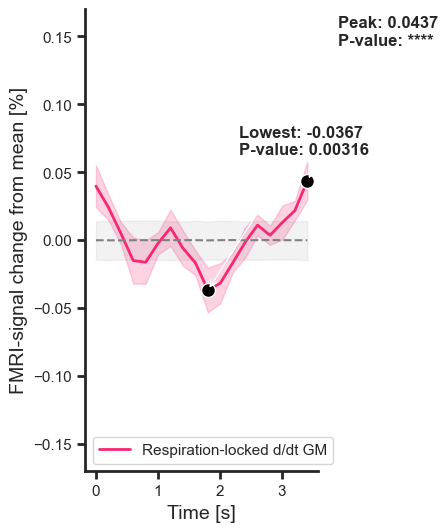

In [15]:



first_value = 0
# Shift all values so the first point is at zero
long_df_respiration_gm["value"] -= first_value

# Now mean the null distribution as well (10.000, 18)
first_value_null = null_respiration_d_dt_gm.mean(axis=0).iloc[0]
null_respiration_d_dt_gm = null_respiration_d_dt_gm - first_value_null
null_mean = np.mean(null_respiration_d_dt_gm, axis=0)  # Mean over permutations
lower_bound = np.percentile(null_respiration_d_dt_gm, 2.5, axis=0)  # 2.5th percentile
upper_bound = np.percentile(null_respiration_d_dt_gm, 97.5, axis=0)  # 97.5th percentile

# Define timepoints (assuming 18 bins), exemplary from subject one
timepoints = long_df_respiration_gm.loc[long_df_respiration_gm['measurement'] == 1, 'timepoint']

fig, ax = plt.subplots(figsize=(3, 6))

# Plot using Seaborn
sns.lineplot(
    data=long_df_respiration_gm,
    x='timepoint',  # Changed from 'subject' to 'timepoint'
    y='value',
    #hue='physiology',
    errorbar='se',  # Shaded region shows standard error
    estimator='mean',  # Mean line
    linewidth=2,
    color=(249/255, 38/255, 114/255),  # Reddish for other data
    label='Respiration-locked d/dt GM'
)

# Plot null distribution mean with shaded confidence interval
ax.plot(timepoints, null_mean, color="gray", linestyle="dashed", label="Null Mean")
ax.fill_between(timepoints, lower_bound, upper_bound, color="gray", alpha=0.1, label="Null 95% CI")
    
# Now do the statistics - Peak
# Extract peak value and index
mean_pfi = long_df_respiration_gm.groupby("timepoint")["value"].mean()
peak_timepoint = mean_pfi.idxmax()  # Get timepoint of the max value
peak_value = mean_pfi.max()  # Get the max value itself
time_interval = timepoints[1] - timepoints[0]  # Interval between timepoints
peak_timepoint_index = int(round(peak_timepoint / time_interval))

# Extract observed values at the peak timepoint
observed_values_at_peak = long_df_respiration_gm.loc[long_df_respiration_gm['timepoint'] == peak_timepoint, 'value'].values

# Extract null distribution values at the same peak timepoint index
null_values_at_peak = null_respiration_d_dt_gm.iloc[:, peak_timepoint_index]

print(observed_values_at_peak)
print(observed_values_at_peak.mean())
print(null_values_at_peak)
# Perform Mann-Whitney U test to compare observed values at peak with null values at the same timepoint
stat, p_value = mannwhitneyu(observed_values_at_peak, null_values_at_peak, alternative='two-sided')

# Step 5: Output the p-value
print(f"Mann-Whitney U Test p-value: {p_value}")
# Print formatted p-value or asterisks
if p_value < 0.00001:
    p_value = '****'
else:
    p_value = f'{p_value:.5f}'  # Format the p-value with 5 decimal places

# Mark the peak value with a circle
ax.scatter(peak_timepoint, peak_value, color="black", edgecolor="white", s=100, zorder=3, label="Observed Peak")

# Check if p_value is a string (i.e., '****')
if isinstance(p_value, str):
    annotation_text = f"Peak: {peak_value:.4f}\nP-value: {p_value}"
else:
    annotation_text = f"Peak: {peak_value:.4f}\nP-value: {p_value:.4f}"

# Annotate peak value and p-value
ax.annotate(annotation_text, 
            xy=(peak_timepoint, peak_value), 
            xytext=(peak_timepoint + 0.5, peak_value + 0.1),  # Offset text
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            fontsize=12, weight='bold')

# Now do the statistics - Lowest
# Extract peak value and index
mean_pfi = long_df_respiration_gm.groupby("timepoint")["value"].mean()
peak_timepoint = mean_pfi.idxmin()  # Get timepoint of the max value
peak_value = mean_pfi.min()  # Get the max value itself
time_interval = timepoints[1] - timepoints[0]  # Interval between timepoints
peak_timepoint_index = int(round(peak_timepoint / time_interval))

# Extract observed values at the peak timepoint
observed_values_at_peak = long_df_respiration_gm.loc[long_df_respiration_gm['timepoint'] == peak_timepoint, 'value'].values

# Extract null distribution values at the same peak timepoint index
null_values_at_peak = null_respiration_d_dt_gm.iloc[:, peak_timepoint_index]

print(observed_values_at_peak)
print(observed_values_at_peak.mean())
print(null_values_at_peak)
# Perform Mann-Whitney U test to compare observed values at peak with null values at the same timepoint
stat, p_value = mannwhitneyu(observed_values_at_peak, null_values_at_peak, alternative='two-sided')

# Step 5: Output the p-value
print(f"Mann-Whitney U Test p-value: {p_value}")
# Print formatted p-value or asterisks
if p_value < 0.00001:
    p_value = '****'
else:
    p_value = f'{p_value:.5f}'  # Format the p-value with 5 decimal places

# Mark the peak value with a circle
ax.scatter(peak_timepoint, peak_value, color="black", edgecolor="white", s=100, zorder=3, label="Observed Peak")

# Check if p_value is a string (i.e., '****')
if isinstance(p_value, str):
    annotation_text = f"Lowest: {peak_value:.4f}\nP-value: {p_value}"
else:
    annotation_text = f"Lowest: {peak_value:.4f}\nP-value: {p_value:.4f}"

# Annotate peak value and p-value
ax.annotate(annotation_text, 
            xy=(peak_timepoint, peak_value), 
            xytext=(peak_timepoint + 0.5, peak_value + 0.1),  # Offset text
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            fontsize=12, weight='bold')




plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('FMRI-signal change from mean [%]', fontsize=14)
ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed


sns.despine()
plt.ylim(-0.17,0.17)

# Save the figure -------
#image_path = os.path.join(outDir, f'GM_respiration.png')
#fig.savefig(image_path,dpi=600, bbox_inches='tight')
#---
#image_path_svg = os.path.join(outDir, f'GM_respiration.svg')
#fig.savefig(image_path_svg)


# ==============================================================
# Amplitude Test: Observed (peak - trough) vs Null Distribution
# ==============================================================


# Each row is one permutation → amplitude = max - min across bins
null_amplitudes = null_respiration_d_dt_gm.max(axis=1) - null_respiration_d_dt_gm.min(axis=1)

print(f"Computed {len(null_amplitudes)} null amplitudes")
print(f"Example null amplitudes: {null_amplitudes[:10]}")
print(f"Mean null amplitude: {null_amplitudes.mean():.4f}")

# Subject amplitudes: max-min per subject trace
subject_amplitudes = (
    long_df_respiration_gm.groupby("measurement")["value"].apply(lambda x: x.max() - x.min())
)

print("Subject amplitudes:")
print(subject_amplitudes.values)

# Mann–Whitney U: compares subject amplitude distribution vs null
stat, p_value_subjects = mannwhitneyu(subject_amplitudes, null_amplitudes, alternative="two-sided")

print(f"Median subject amplitude: {subject_amplitudes.median():.4f}")
print(f"Mean null amplitude: {null_amplitudes.mean():.4f}")
print(f"Mann-Whitney U p-value: {p_value_subjects:.5f}")


# Panel 5J

5
One-sample t-test at lag 5: t = -3.924, p = 0.00202
-0.15857720565798963
0.1457158812145026
1.137924336180484


/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_6550/3615862362.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_lags_at_min_corr = pd.concat([df_lags_at_min_corr, pd.DataFrame({'subject': [subject], 'min_corr_lag': [min_corr_lag]})], ignore_index=True)


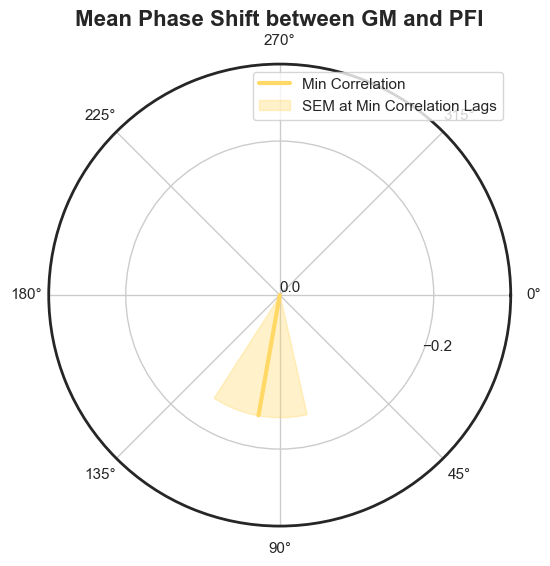

In [19]:


# Ensure dataframes are sorted by subject and timepoint
df_gm = long_df_respiration_gm.sort_values(by=['measurement', 'timepoint'])
df_pfi = long_df_respiration_pfi.sort_values(by=['measurement', 'timepoint'])

# Get unique subjects (ensure integer formatting)
subjects = df_gm['measurement'].unique()
subjects = np.sort(subjects)  # Ensure proper order

# Store cross-correlation results
df_xcorr = pd.DataFrame()

# Store lags at max correlation for each subject
df_lags_at_min_corr = pd.DataFrame(columns=['subject', 'min_corr_lag'])

for subject in subjects:
    # Extract subject-specific timecourses
    gm_values = df_gm[df_gm['measurement'] == subject].pivot(index="timepoint", columns="measurement", values="value")
    pfi_values = df_pfi[df_pfi['measurement'] == subject].pivot(index="timepoint", columns="measurement", values="value")

    #print(pfi_values)

    # Ensure both signals are aligned (use common timepoints)
    common_timepoints = gm_values.index.intersection(pfi_values.index)
    gm_values = gm_values.loc[common_timepoints].mean(axis=1)  # Average over measurements
    pfi_values = pfi_values.loc[common_timepoints].mean(axis=1)  # Average over measurements

    #print(pfi_values)

    # Normalize the pfi_values and csf_values
    norm_gm = np.linalg.norm(gm_values)
    gm_values = gm_values / norm_gm

    norm_pfi = np.linalg.norm(pfi_values)
    pfi_values = pfi_values / norm_pfi

    # Compute cross-correlation using SciPy
    corr_values = correlate(gm_values, pfi_values, mode='full', method='auto')
    lags = np.arange(-len(common_timepoints) + 1, len(common_timepoints))  # Corresponding lag times

    # Find the lag with the maximum correlation for the subject
    min_corr_idx = np.argmax(corr_values)
    min_corr_lag = lags[min_corr_idx]  # Lag of max correlation

    # Store the max correlation lag for this subject
    df_lags_at_min_corr = pd.concat([df_lags_at_min_corr, pd.DataFrame({'subject': [subject], 'min_corr_lag': [min_corr_lag]})], ignore_index=True)

    # Store results in DataFrame
    temp_df = pd.DataFrame({'subject': subject, 'lag': lags, 'correlation': corr_values})
    df_xcorr = pd.concat([df_xcorr, temp_df], ignore_index=True)

#print(df_xcorr)

# Compute mean cross-correlation over subjects
df_mean_xcorr = df_xcorr.groupby('lag')['correlation'].mean().reset_index()



# Compute the SEM of the lags at max correlation across all subjects
df_lags_sem = df_lags_at_min_corr['min_corr_lag'].sem()

# Find the lag corresponding to the maximum mean correlation
min_corr_idx = df_mean_xcorr['correlation'].idxmin()  # Index of max correlation
min_corr_value = df_mean_xcorr.loc[min_corr_idx, 'correlation']  # Maximum correlation value
min_corr_lag = df_mean_xcorr.loc[min_corr_idx, 'lag']  # Lag corresponding to max correlation

print(min_corr_lag)

#-----
# Add test whether different from zero at the lag:
# Define the lag of interest
target_lag = min_corr_lag

# Extract all individual correlation values at lag = 100°
corr_at_lag = df_xcorr[df_xcorr['lag'] == target_lag]['correlation']

# Perform one-sample t-test against 0
t_stat, p_val = stats.ttest_1samp(corr_at_lag, 0)

print(f"One-sample t-test at lag {target_lag}: t = {t_stat:.3f}, p = {p_val:.5f}")
print(corr_at_lag.mean())
print(corr_at_lag.std())
#-------


# Convert lag of max correlation to angle
min_angle = np.radians(min_corr_lag * (360 / len(common_timepoints)))

# Convert time shift to phase shift
cycle_length = max(common_timepoints) - min(common_timepoints)  # Full cycle duration




# Convert lags to angles
angles = np.radians(df_mean_xcorr['lag'] * (360 / len(common_timepoints)))

# Create Polar Plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))


# Plot the maximum correlation at its corresponding lag
ax.plot([min_angle, min_angle], [0, min_corr_value], color=(1.0, 0.8470588235294118, 0.4019607843137251), label="Min Correlation", linewidth=3)

# Convert SEM of the lags into angle space
sem_angle = np.radians(df_lags_sem * (360 / len(common_timepoints)))

print(df_lags_sem)

# Create an angle range with smooth edges for SEM
angles_range = np.linspace(min_angle - sem_angle, min_angle + sem_angle, 100)

# Define the SEM height, scaled to match the max_corr_value
sem_y_values = np.full_like(angles_range, min_corr_value)  # Create an array filled with max_corr_value

# Now add SEM shading smoothly to the plot
ax.fill_between(angles_range, 0, sem_y_values, 
                color=(1.0, 0.8470588235294118, 0.4019607843137251), alpha=0.35, label="SEM at Min Correlation Lags")

ax.set_theta_zero_location("E")  # Set 0° to the right
ax.set_theta_direction(-1)  # Set direction to counterclockwise
# Set y-axis range from 0 to 1 and show ticks
ax.set_ylim(0, -0.3)  # Set y-axis range
ax.set_yticks([0, -0.2])  # Customize radial ticks to show scale from 0 to 1
ax.set_title("Mean Phase Shift between GM and PFI", fontsize=16, weight='bold')


plt.legend()
plt.show()

# Save the figure -------
#image_path = os.path.join(outDir, f'Polar_plot_GM_PFI.png')
#fig.savefig(image_path,dpi=600, bbox_inches='tight')
#---
#image_path_svg = os.path.join(outDir, f'Polar_plot_GM_PFI.svg')
#fig.savefig(image_path_svg)



# Panel 5K

/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_6550/2280747317.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  offset = np.trapz(mean_signal, dx=1) / len(mean_signal)


[11.31389055  9.18910657 -1.76584628  5.39979929  5.76134371  3.63438137
  3.20760912  2.88725122  3.62152991 -2.15927896 -1.47178904 -2.06737801
 -0.62559779]
2.840386282679407
0      -0.227493
1      -0.091558
2      -0.484367
3       0.388384
4      -1.092895
          ...   
9994    0.521476
9995   -0.726819
9996   -0.142812
9997   -0.305595
9998   -1.617246
Name: 0.6728596100311053, Length: 9999, dtype: float64
Mann-Whitney U Test p-value: 0.10086347423162927
[ -6.62797685 -14.65136028  -7.86822346   0.68457177  -2.87218151
  -7.30540296   3.21074787   2.95958824   2.40911595  -1.39218639
  -3.70216334  -3.55403149  -1.94795555]
-3.127496770151276
0      -0.522230
1      -0.140318
2      -0.315533
3      -0.343648
4       0.102477
          ...   
9994    1.084212
9995   -0.853322
9996   -0.511352
9997   -0.691627
9998    0.378161
Name: -0.1673148063505079, Length: 9999, dtype: float64
Mann-Whitney U Test p-value: 0.011328043546491069


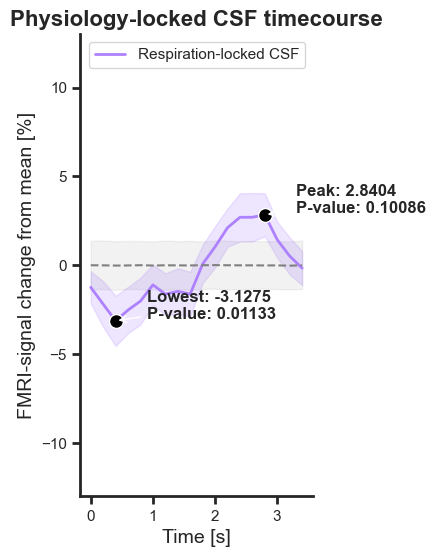

Computed 9999 null amplitudes
Example null amplitudes: 0    2.464213
1    2.960858
2    2.555448
3    2.491753
4    3.300751
5    1.888180
6    4.200235
7    2.387286
8    2.745700
9    2.192276
dtype: float64
Mean null amplitude: 2.5881
Subject amplitudes:
[18.87331739 27.69131602 15.77761822  6.4568136  14.57745771 12.81759884
  3.21427729  1.51931064  1.84244321  6.00645755 14.15224678 11.07533249
  5.99742034]
Median subject amplitude: 11.0753
Mean null amplitude: 2.5881
Mann-Whitney U p-value: 0.00002


In [17]:
# Compute the offset for oscillation correction
# Compute the mean across timepoints
mean_signal = long_df_respiration_csf.groupby("timepoint")["value"].mean()

# Estimate area under the curve (AUC) using trapezoidal integration
# (Assumes timepoints are uniformly spaced)
offset = np.trapz(mean_signal, dx=1) / len(mean_signal)

# Subtract the offset from all values to center integral at zero
long_df_respiration_csf["value"] -= offset

# Now mean the null distribution as well (10.000, 18)
first_value_null = null_respiration_csf.mean(axis=0).iloc[0]
null_respiration_csf = null_respiration_csf - first_value_null
null_mean = np.mean(null_respiration_csf, axis=0)  # Mean over permutations
lower_bound = np.percentile(null_respiration_csf, 2.5, axis=0)  # 2.5th percentile
upper_bound = np.percentile(null_respiration_csf, 97.5, axis=0)  # 97.5th percentile

# Define timepoints (assuming 18 bins), exemplary from subject one
timepoints = long_df_respiration_csf.loc[long_df_respiration_csf['measurement'] == 1, 'timepoint']

# Plot using Seaborn
fig, ax = plt.subplots(figsize=(3, 6))
sns.lineplot(
    data=long_df_respiration_csf,
    x='timepoint',  # Changed from 'subject' to 'timepoint'
    y='value',
    errorbar='se',  # Shaded region shows standard error
    estimator='mean',  # Mean line
    linewidth=2,
    color=(174/255, 129/255, 255/255),  # Reddish for other data
    ax=ax,
    label='Respiration-locked CSF'
)

# Plot null distribution mean with shaded confidence interval
ax.plot(timepoints, null_mean, color="gray", linestyle="dashed", label="Null Mean")
ax.fill_between(timepoints, lower_bound, upper_bound, color="gray", alpha=0.1, label="Null 95% CI")
    
# Now do the statistics - Peak
# Extract peak value and index
mean_pfi = long_df_respiration_csf.groupby("timepoint")["value"].mean()
peak_timepoint = mean_pfi.idxmax()  # Get timepoint of the max value
peak_value = mean_pfi.max()  # Get the max value itself
time_interval = timepoints[1] - timepoints[0]  # Interval between timepoints
peak_timepoint_index = int(round(peak_timepoint / time_interval))

# Extract observed values at the peak timepoint
observed_values_at_peak = long_df_respiration_csf.loc[long_df_respiration_csf['timepoint'] == peak_timepoint, 'value'].values

# Extract null distribution values at the same peak timepoint index
null_values_at_peak = null_respiration_csf.iloc[:, peak_timepoint_index]

print(observed_values_at_peak)
print(observed_values_at_peak.mean())
print(null_values_at_peak)
# Perform Mann-Whitney U test to compare observed values at peak with null values at the same timepoint
stat, p_value = mannwhitneyu(observed_values_at_peak, null_values_at_peak, alternative='two-sided')

# Step 5: Output the p-value
print(f"Mann-Whitney U Test p-value: {p_value}")
# Print formatted p-value or asterisks
if p_value < 0.00001:
    p_value = '****'
else:
    p_value = f'{p_value:.5f}'  # Format the p-value with 5 decimal places

# Mark the peak value with a circle
ax.scatter(peak_timepoint, peak_value, color="black", edgecolor="white", s=100, zorder=3, label="Observed Peak")

# Check if p_value is a string (i.e., '****')
if isinstance(p_value, str):
    annotation_text = f"Peak: {peak_value:.4f}\nP-value: {p_value}"
else:
    annotation_text = f"Peak: {peak_value:.4f}\nP-value: {p_value:.4f}"

# Annotate peak value and p-value
ax.annotate(annotation_text, 
            xy=(peak_timepoint, peak_value), 
            xytext=(peak_timepoint + 0.5, peak_value + 0.1),  # Offset text
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            fontsize=12, weight='bold')


# Now do the statistics - Lowest
# Extract peak value and index
mean_pfi = long_df_respiration_csf.groupby("timepoint")["value"].mean()
peak_timepoint = mean_pfi.idxmin()  # Get timepoint of the max value
peak_value = mean_pfi.min()  # Get the max value itself
time_interval = timepoints[1] - timepoints[0]  # Interval between timepoints
peak_timepoint_index = int(round(peak_timepoint / time_interval))

# Extract observed values at the peak timepoint
observed_values_at_peak = long_df_respiration_csf.loc[long_df_respiration_csf['timepoint'] == peak_timepoint, 'value'].values

# Extract null distribution values at the same peak timepoint index
null_values_at_peak = null_respiration_csf.iloc[:, peak_timepoint_index]

print(observed_values_at_peak)
print(observed_values_at_peak.mean())
print(null_values_at_peak)
# Perform Mann-Whitney U test to compare observed values at peak with null values at the same timepoint
stat, p_value = mannwhitneyu(observed_values_at_peak, null_values_at_peak, alternative='two-sided')

# Step 5: Output the p-value
print(f"Mann-Whitney U Test p-value: {p_value}")
# Print formatted p-value or asterisks
if p_value < 0.00001:
    p_value = '****'
else:
    p_value = f'{p_value:.5f}'  # Format the p-value with 5 decimal places

# Mark the peak value with a circle
ax.scatter(peak_timepoint, peak_value, color="black", edgecolor="white", s=100, zorder=3, label="Observed Lowest")

# Check if p_value is a string (i.e., '****')
if isinstance(p_value, str):
    annotation_text = f"Lowest: {peak_value:.4f}\nP-value: {p_value}"
else:
    annotation_text = f"Lowest: {peak_value:.4f}\nP-value: {p_value:.4f}"

# Annotate peak value and p-value
ax.annotate(annotation_text, 
            xy=(peak_timepoint, peak_value), 
            xytext=(peak_timepoint + 0.5, peak_value + 0.1),  # Offset text
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            fontsize=12, weight='bold')


plt.title(f"Physiology-locked CSF timecourse", fontsize=16, weight='bold')
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('FMRI-signal change from mean [%]', fontsize=14)
ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
for spine in ax.spines.values():
    spine.set_linewidth(2)

sns.despine()
plt.ylim(-13,13)
plt.show()

# Save the figure -------
#image_path = os.path.join(outDir, f'CSF_respiration.png')
#fig.savefig(image_path,dpi=600, bbox_inches='tight')
#---
#image_path_svg = os.path.join(outDir, f'CSF_respiration.svg')
#fig.savefig(image_path_svg)

# ==============================================================
# Amplitude Test: Observed (peak - trough) vs Null Distribution
# ==============================================================

# Each row is one permutation → amplitude = max - min across bins
null_amplitudes = null_respiration_csf.max(axis=1) - null_respiration_csf.min(axis=1)

print(f"Computed {len(null_amplitudes)} null amplitudes")
print(f"Example null amplitudes: {null_amplitudes[:10]}")
print(f"Mean null amplitude: {null_amplitudes.mean():.4f}")

# Subject amplitudes: max-min per subject trace
subject_amplitudes = (
    long_df_respiration_csf.groupby("measurement")["value"].apply(lambda x: x.max() - x.min())
)

print("Subject amplitudes:")
print(subject_amplitudes.values)

# Mann–Whitney U: compares subject amplitude distribution vs null
stat, p_value_subjects = mannwhitneyu(subject_amplitudes, null_amplitudes, alternative="two-sided")

print(f"Median subject amplitude: {subject_amplitudes.median():.4f}")
print(f"Mean null amplitude: {null_amplitudes.mean():.4f}")
print(f"Mann-Whitney U p-value: {p_value_subjects:.5f}")

# Panel 5L

4
One-sample t-test at lag 4: t = 2.898, p = 0.01337
0.22677754234730005
0.28214115038768134


/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_6550/3507017496.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_lags_at_max_corr = pd.concat([df_lags_at_max_corr, pd.DataFrame({'subject': [subject], 'max_corr_lag': [max_corr_lag]})], ignore_index=True)


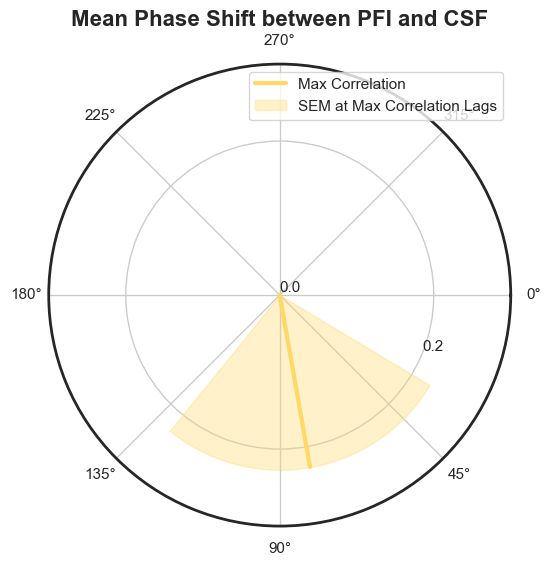

In [18]:
# Ensure dataframes are sorted by subject and timepoint
df_pfi = long_df_respiration_pfi.sort_values(by=['measurement', 'timepoint'])
df_csf = long_df_respiration_csf.sort_values(by=['measurement', 'timepoint'])

# Get unique subjects (ensure integer formatting)
subjects = df_pfi['measurement'].unique()
subjects = np.sort(subjects)  # Ensure proper order

# Store cross-correlation results
df_xcorr = pd.DataFrame()

# Store lags at max correlation for each subject
df_lags_at_max_corr = pd.DataFrame(columns=['subject', 'max_corr_lag'])

for subject in subjects:
    # Extract subject-specific timecourses
    pfi_values = df_pfi[df_pfi['measurement'] == subject].pivot(index="timepoint", columns="measurement", values="value")
    csf_values = df_csf[df_csf['measurement'] == subject].pivot(index="timepoint", columns="measurement", values="value")

    #print(pfi_values)

    # Ensure both signals are aligned (use common timepoints)
    common_timepoints = pfi_values.index.intersection(csf_values.index)
    pfi_values = pfi_values.loc[common_timepoints].mean(axis=1)  # Average over measurements
    csf_values = csf_values.loc[common_timepoints].mean(axis=1)  # Average over measurements

    #print(pfi_values)

    # Normalize the pfi_values and csf_values
    norm_pfi = np.linalg.norm(pfi_values)
    pfi_values = pfi_values / norm_pfi

    norm_csf = np.linalg.norm(csf_values)
    csf_values = csf_values / norm_csf

    # Compute cross-correlation using SciPy
    corr_values = correlate(pfi_values, csf_values, mode='full', method='auto')
    lags = np.arange(-len(common_timepoints) + 1, len(common_timepoints))  # Corresponding lag times

    # Normalize the cross-correlation values per subject
    #corr_values /= (np.std(pfi_values) * np.std(csf_values) * len(common_timepoints))
    # Find the lag with the maximum correlation for the subject
    max_corr_idx = np.argmax(corr_values)
    max_corr_lag = lags[max_corr_idx]  # Lag of max correlation

    # Store the max correlation lag for this subject
    df_lags_at_max_corr = pd.concat([df_lags_at_max_corr, pd.DataFrame({'subject': [subject], 'max_corr_lag': [max_corr_lag]})], ignore_index=True)

    # Store results in DataFrame
    temp_df = pd.DataFrame({'subject': subject, 'lag': lags, 'correlation': corr_values})
    df_xcorr = pd.concat([df_xcorr, temp_df], ignore_index=True)

#print(df_xcorr)

# Compute mean cross-correlation over subjects
df_mean_xcorr = df_xcorr.groupby('lag')['correlation'].mean().reset_index()


# Compute the SEM of the lags at max correlation across all subjects
df_lags_sem = df_lags_at_max_corr['max_corr_lag'].sem()

# Find the lag corresponding to the maximum mean correlation
max_corr_idx = df_mean_xcorr['correlation'].idxmax()  # Index of max correlation
max_corr_value = df_mean_xcorr.loc[max_corr_idx, 'correlation']  # Maximum correlation value
max_corr_lag = df_mean_xcorr.loc[max_corr_idx, 'lag']  # Lag corresponding to max correlation

print(max_corr_lag)
#-----
# Add test whether different from zero at the lag:
# Define the lag of interest
target_lag = max_corr_lag

# Extract all individual correlation values at lag = -2
corr_at_lag = df_xcorr[df_xcorr['lag'] == target_lag]['correlation']

# Perform one-sample t-test against 0
t_stat, p_val = stats.ttest_1samp(corr_at_lag, 0)

print(f"One-sample t-test at lag {target_lag}: t = {t_stat:.3f}, p = {p_val:.5f}")
print(corr_at_lag.mean())
print(corr_at_lag.std())
#-------


# Convert lag of max correlation to angle
max_angle = np.radians(max_corr_lag * (360 / len(common_timepoints)))

# Convert time shift to phase shift
cycle_length = max(common_timepoints) - min(common_timepoints)  # Full cycle duration



# Convert lags to angles
angles = np.radians(df_mean_xcorr['lag'] * (360 / len(common_timepoints)))

# Create Polar Plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
# Plot the maximum correlation at its corresponding lag
ax.plot([max_angle, max_angle], [0, max_corr_value], color=(1.0, 0.8470588235294118, 0.4019607843137251), label="Max Correlation", linewidth=3)

ax.set_theta_zero_location("E")  # Set 0° to the right
ax.set_theta_direction(-1)  # Set direction to counterclockwise
# Set y-axis range from 0 to 1 and show ticks
ax.set_ylim(0, 0.3)  # Set y-axis range
ax.set_yticks([0, 0.2])  # Customize radial ticks to show scale from 0 to 1
ax.set_title("Mean Phase Shift between PFI and CSF", fontsize=16, weight='bold')

# Convert SEM of the lags into angle space
sem_angle = np.radians(df_lags_sem * (360 / len(common_timepoints)))

#print(df_lags_sem)

# Create an angle range with smooth edges for SEM
angles_range = np.linspace(max_angle - sem_angle, max_angle + sem_angle, 100)

# Define the SEM height, scaled to match the max_corr_value
sem_y_values = np.full_like(angles_range, max_corr_value)  # Create an array filled with max_corr_value

# Now add SEM shading smoothly to the plot
ax.fill_between(angles_range, 0, sem_y_values, 
                color=(1.0, 0.8470588235294118, 0.4019607843137251), alpha=0.35, label="SEM at Max Correlation Lags")



plt.legend()
plt.show()

# Save the figure -------
#image_path = os.path.join(outDir, f'Polar_plot_PFI_CSF.png')
#fig.savefig(image_path,dpi=600, bbox_inches='tight')
#---
#image_path_svg = os.path.join(outDir, f'Polar_plot_PFI_CSF.svg')
#fig.savefig(image_path_svg)

